### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

import scaling as sca
import multianalysis as ma

In [2]:
%matplotlib inline

### Similarity analysis with the following peak alignment: 
#### 1 - 1st alignment: min_sample = 2, 2nd alignment: min_sample = 1 - NAME: 2-1 / Original
#### 2 - 1st alignment: min_sample = 3, 2nd alignment: min_sample = 3 - NAME: 3-3

To better understand the functions used outside of normal Python packages, see scaling.py, multianalysis.py where they are better described and try to say what is happening in each block of code.

In [3]:
def read_aligned_files(filename):
    """Short function to read the aligned files fast while putting the MultiIndex in the correct order for the CDL accessor."""
    df = pd.read_csv(filename, header = None, index_col = [0])
    df.index.name = 'm/z'
    mi = pd.concat([df.iloc[1, :],df.iloc[0, :]], axis = 'columns')
    mi = pd.MultiIndex.from_frame(mi)
    final_file = pd.read_csv(filename, header = [0,1], index_col = [0])
    final_file.columns = mi
    return final_file

## Lists of m/z exclusive of each label - Adapted it to work with new interface

This part isn't in other notebooks

#### Read (reload) aligned from CSV

In [4]:
from metabolinks.similarity import exclusive

In [5]:
aligned_all_pos = read_aligned_files('aligned_1ppm_min3_1ppm_positive.csv')
aligned_all_neg = read_aligned_files('aligned_1ppm_min3_1ppm_negative.csv')

In [6]:
#Only works for 3-X alignments
indexes_pos = []
for i in range(0,len(aligned_all_pos.columns),3):
    indexes_pos.append(aligned_all_pos[aligned_all_pos.iloc[:,i].notnull()].index)
excl = exclusive(indexes_pos)
exclusive_mz_pos = zip(aligned_all_pos.cdl.unique_labels, excl)

indexes_neg = []
for i in range(0,len(aligned_all_neg.columns),3):
    indexes_neg.append(aligned_all_neg[aligned_all_neg.iloc[:,i].notnull()].index)
excl = exclusive(indexes_neg)
exclusive_mz_neg = zip(aligned_all_neg.cdl.unique_labels, excl)

In [7]:
print('------- POSITIVE mode ------------------')
for label, values in exclusive_mz_pos:
    print(f'{label:4} {len(values)}')

#with open('exclusive_pos.txt','w') as ofile:
#    for label, values in aligned_all_pos.exclusive_mz.items():
#        line = '\t'.join([label] + [str(v) for v in values])
#        print(line, file = ofile)

print('------- NEGATIVE mode ------------------')
for label, values in exclusive_mz_neg:
    print(f'{label:4} {len(values)}')

#with open('exclusive_neg.txt','w') as ofile:
#    for label, values in aligned_all_neg.exclusive_mz.items():
#        line = '\t'.join([label] + [str(v) for v in values])
#        print(line, file = ofile)

------- POSITIVE mode ------------------
CAN  16
CS   33
LAB  41
PN   412
REG  234
RIP  4
RL   30
ROT  15
RU   140
TRI  101
CFN  39
CHT  8
SB   21
------- NEGATIVE mode ------------------
CAN  28
CS   103
LAB  47
PN   111
REG  230
RIP  143
RL   17
ROT  199
RU   284
TRI  21
CFN  6
CHT  42
SB   22


In [8]:
aligned_all_pos = read_aligned_files('aligned_1ppm_min3_2ppm_positive.csv')
aligned_all_neg = read_aligned_files('aligned_1ppm_min3_2ppm_negative.csv')

In [9]:
#Only works for 3-X alignments
indexes_pos = []
for i in range(0,len(aligned_all_pos.columns),3):
    indexes_pos.append(aligned_all_pos[aligned_all_pos.iloc[:,i].notnull()].index)
excl = exclusive(indexes_pos)
exclusive_mz_pos = zip(aligned_all_pos.cdl.unique_labels, excl)

indexes_neg = []
for i in range(0,len(aligned_all_neg.columns),3):
    indexes_neg.append(aligned_all_neg[aligned_all_neg.iloc[:,i].notnull()].index)
excl = exclusive(indexes_neg)
exclusive_mz_neg = zip(aligned_all_neg.cdl.unique_labels, excl)

In [10]:
print('------- POSITIVE mode ------------------')
for label, values in exclusive_mz_pos:
    print(f'{label:4} {len(values)}')

#with open('exclusive_pos_2ppm.txt','w') as ofile:
#    for label, values in aligned_all_pos.exclusive_mz.items():
#        line = '\t'.join([label] + [str(v) for v in values])
#        print(line, file = ofile)

print('------- NEGATIVE mode ------------------')
for label, values in exclusive_mz_neg:
    print(f'{label:4} {len(values)}')

#with open('exclusive_neg_2ppm.txt','w') as ofile:
#    for label, values in aligned_all_neg.exclusive_mz.items():
#        line = '\t'.join([label] + [str(v) for v in values])
#        print(line, file = ofile)

------- POSITIVE mode ------------------
CAN  13
CS   22
LAB  37
PN   364
REG  209
RIP  2
RL   19
ROT  9
RU   115
TRI  83
CFN  35
CHT  8
SB   15
------- NEGATIVE mode ------------------
CAN  25
CS   139
LAB  15
PN   60
REG  216
RIP  63
RL   11
ROT  170
RU   202
TRI  18
CFN  7
CHT  34
SB   14


## Similarity analysis

aligned_all_neg = negative dataset alignment 2-1 (Original) / aligned_neg - binary matrix equivalent

aligned_all_pos = positive dataset alignment 2-1 (Original) / aligned_pos - binary matrix equivalent

aligned_all_neg2 = negative dataset alignment 3-3 / aligned_neg2 - binary matrix equivalent

aligned_all_pos2 = positive dataset alignment 3-3 / aligned_pos2 - binary matrix equivalent

### Read aligned data of the 1st alignment 2-1 - Analysis of this one first

In [11]:
aligned_all_pos = read_aligned_files('aligned_1ppm_min2_1ppm_positive.csv')
aligned_all_neg = read_aligned_files('aligned_1ppm_min2_1ppm_negative.csv')

#### Compute m/z similarities

In [12]:
sim_pos = mz_similarity(aligned_all_pos, has_labels = True)
sim_neg = mz_similarity(aligned_all_neg, has_labels = True)

In [13]:
print(sim_pos)


Sample similarity, counts of common peaks
          14   15   16   29   30   31    8    9   10    23  ...    34  \
14       330  277  253  202  200  195  207  214  207   152  ...   175   
15       277  379  302  233  232  224  227  231  223   179  ...   201   
16       253  302  355  222  222  218  212  212  208   164  ...   189   
29       202  233  222  667  514  526  230  233  235   308  ...   351   
30       200  232  222  514  612  471  236  236  235   284  ...   326   
31       195  224  218  526  471  624  232  237  239   294  ...   338   
8        207  227  212  230  236  232  489  399  369   182  ...   205   
9        214  231  212  233  236  237  399  501  381   184  ...   218   
10       207  223  208  235  235  239  369  381  471   181  ...   221   
23       152  179  164  308  284  294  182  184  181  1487  ...   431   
24       151  176  162  308  286  297  187  190  188  1246  ...   443   
25       146  174  159  296  269  286  177  179  180  1095  ...   429   
38      

In [14]:
print(sim_neg)


Sample similarity, counts of common peaks
          14   15   16   29   30   31    8    9   10   23  ...   34  10713-1  \
14       442  286  345  186  183  170  168  179  179   34  ...  151        6   
15       286  319  222  121  118  108  144  157  155   25  ...  146        4   
16       345  222  378  174  171  159  168  181  177   34  ...  148        4   
29       186  121  174  674  637  588  143  151  150   88  ...  202       16   
30       183  118  171  637  677  591  142  150  149   88  ...  214       22   
31       170  108  159  588  591  628  128  135  135   87  ...  184       22   
8        168  144  168  143  142  128  370  331  339  118  ...  131        4   
9        179  157  181  151  150  135  331  402  371  111  ...  138        4   
10       179  155  177  150  149  135  339  371  410  120  ...  138        4   
23        34   25   34   88   88   87  118  111  120  350  ...   23       10   
24        46   33   45   95   95   94  127  121  129  314  ...   30       10 

In [15]:
dfpos = pd.DataFrame(sim_pos.sample_similarity_jaccard,
                     columns=aligned_all_pos.cdl.samples,
                     index=aligned_all_pos.cdl.samples)

dfneg = pd.DataFrame(sim_neg.sample_similarity_jaccard,
                     columns=aligned_all_neg.cdl.samples,
                     index=aligned_all_neg.cdl.samples)

Sample similarity, positive mode


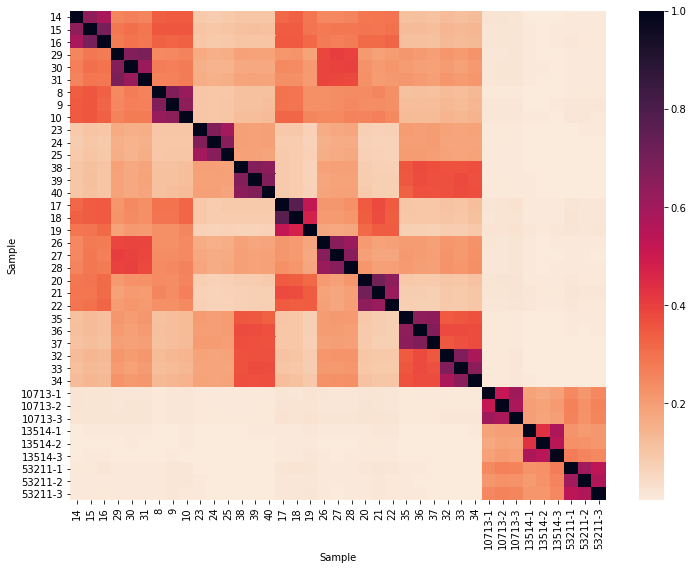

In [16]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, positive mode')
hm = sns.heatmap(dfpos, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Sample similarity, negative mode


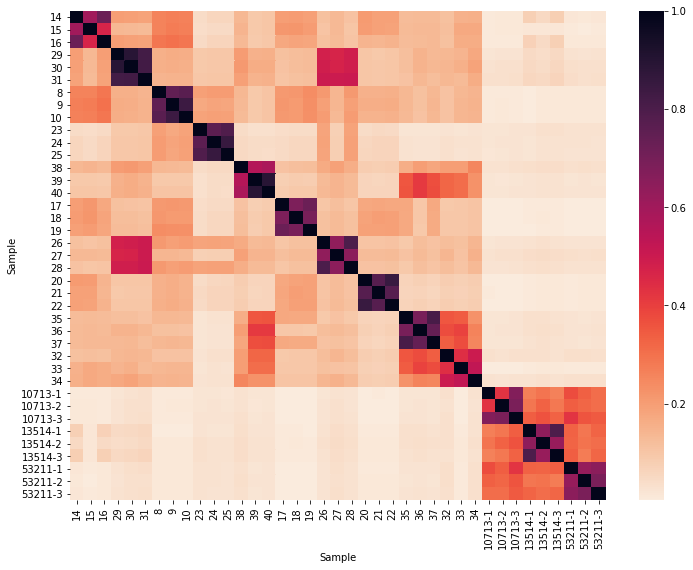

In [17]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, negative mode')
hm = sns.heatmap(dfneg, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [18]:
dfpos = pd.DataFrame(sim_pos.label_similarity_jaccard,
                     columns=aligned_all_pos.cdl.unique_labels,
                     index=aligned_all_pos.cdl.unique_labels)

dfneg = pd.DataFrame(sim_neg.label_similarity_jaccard,
                     columns=aligned_all_neg.cdl.unique_labels,
                     index=aligned_all_neg.cdl.unique_labels)

Label similarity, positive mode


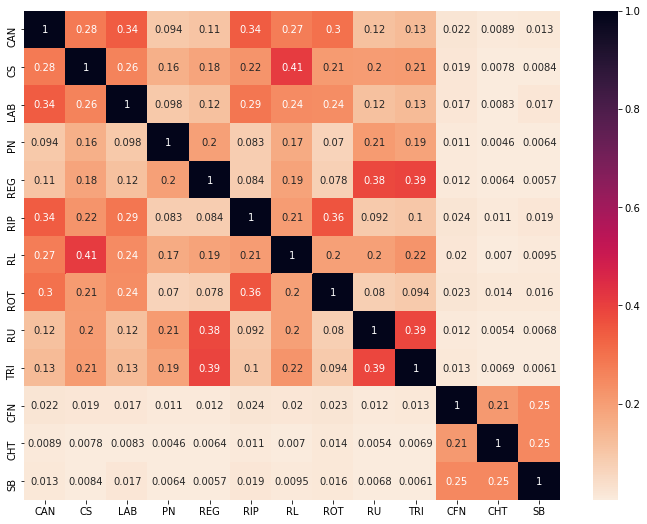

In [19]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, positive mode')
hm = sns.heatmap(dfpos, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Label similarity, negative mode


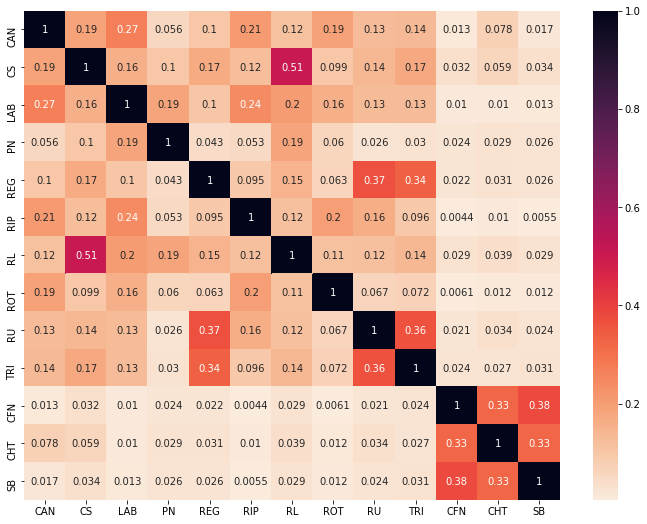

In [20]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, negative mode')
hm = sns.heatmap(dfneg, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### Clustermap peak list function

In [21]:
def clustermap_peak_list(aligned):
    aligned_01 = aligned.copy()
    aligned_01[aligned_01.notnull()] = 1
    aligned_01[aligned_01.isnull()] = 0
    aligned_01.columns = aligned_01.cdl.samples

    ulabels = aligned.cdl.unique_labels
    n = len(ulabels)
    
    p = sns.color_palette() + sns.color_palette("Set1", n_colors=n-10, desat=.5)
    sample_to_labels = pd.Series(aligned.cdl.labels, index=aligned.cdl.samples)
    label_colors = pd.Series(p, index=ulabels)
    sample_colors = sample_to_labels.map(label_colors)
    
    g = sns.clustermap(aligned_01, metric="jaccard", figsize=(15, 20), 
                       row_cluster=False,
                       col_colors=sample_colors,
                       yticklabels=False)
    # fix bug in seaborn, error in clustermap if cbar == False
    ax=g.cax; aax=ax.clear(); aax = ax.axis('off'); 

    # draw legend
    lpatches = [mpatches.Patch(color=c, label=lbl) for (lbl, c) in label_colors.iteritems()]
    leg = plt.legend(handles=lpatches, fontsize=20)
    return g

Sample HC, NEGATIVE mode


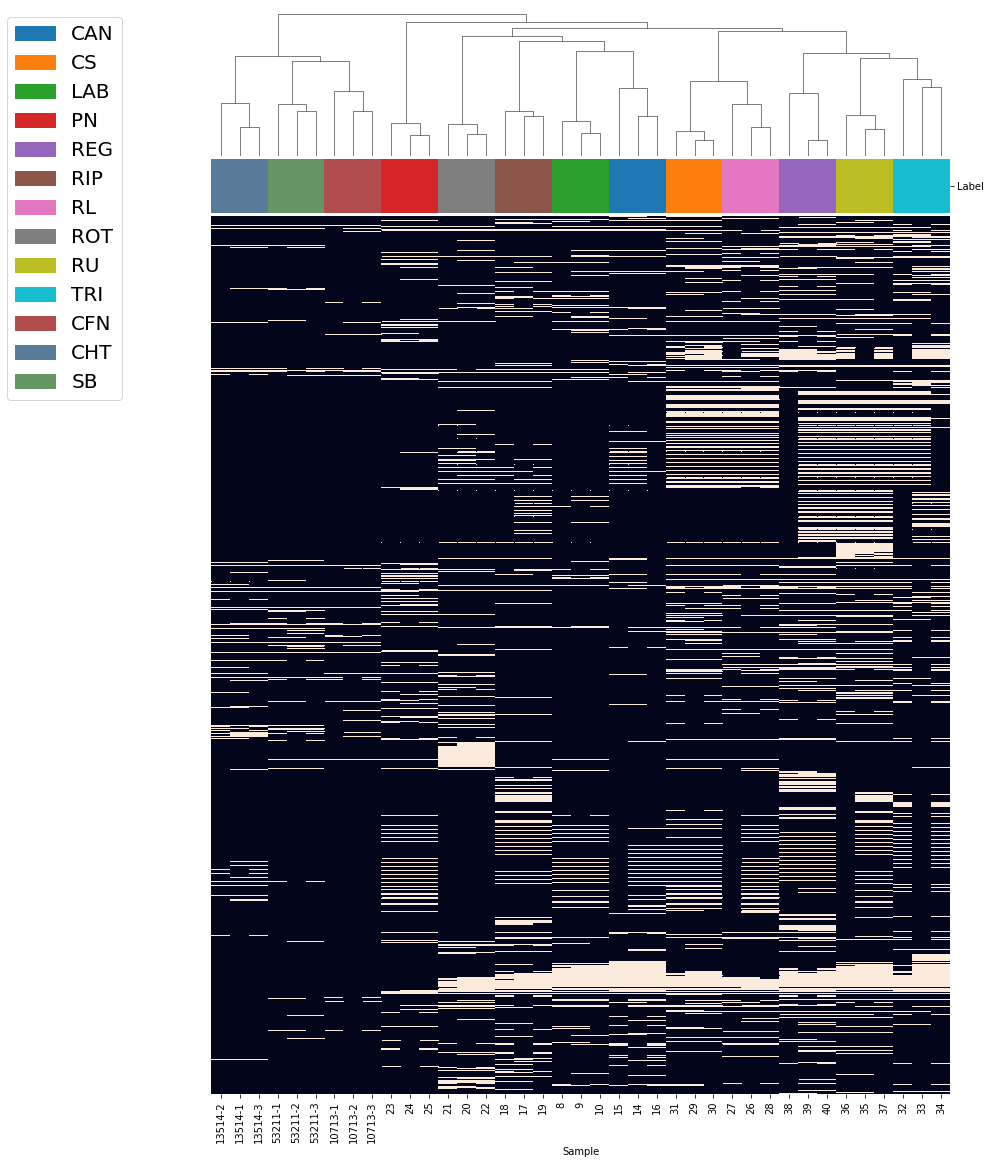

In [22]:
print('Sample HC, NEGATIVE mode')
g = clustermap_peak_list(aligned_all_neg)

Sample HC, POSITIVE mode


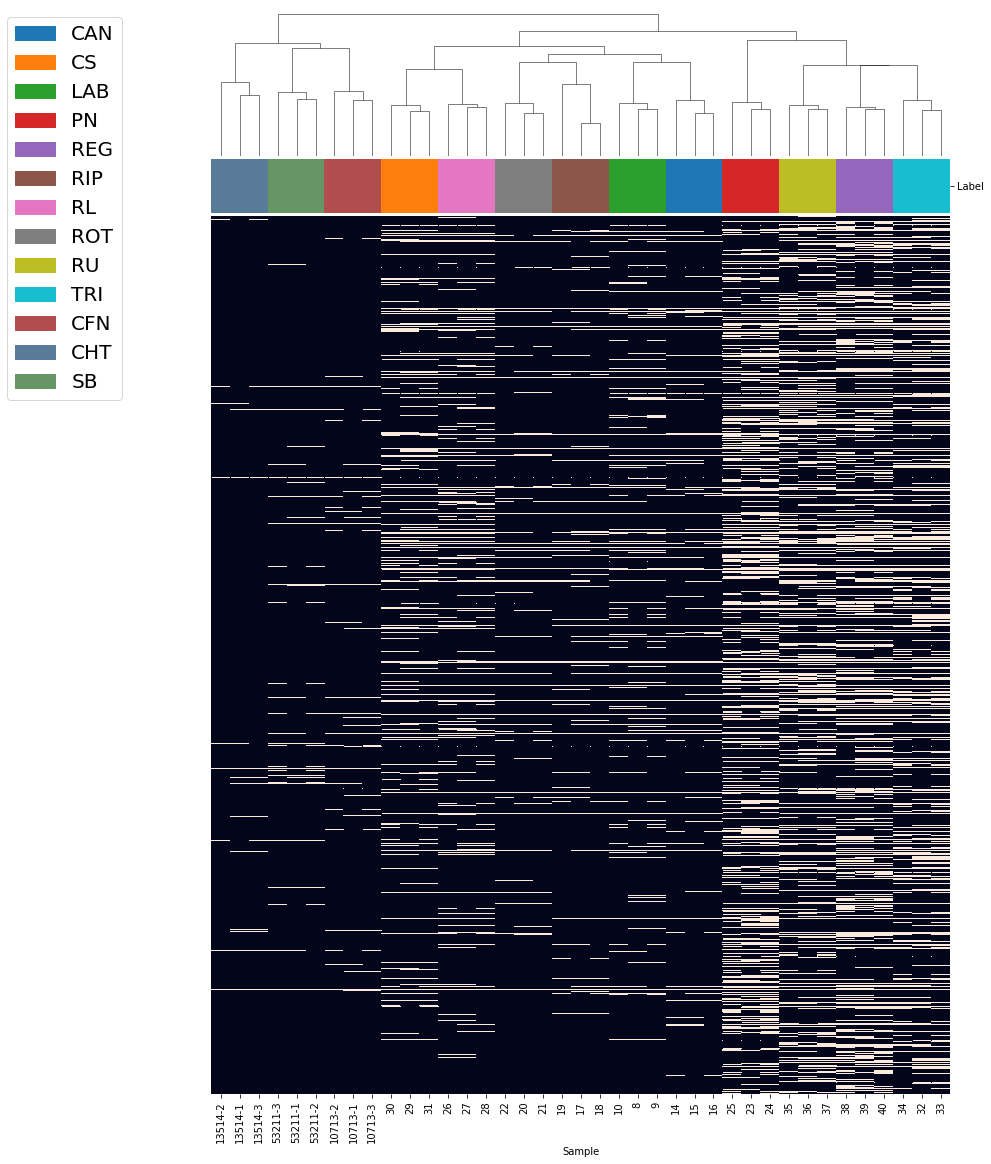

In [23]:
print('Sample HC, POSITIVE mode')
g = clustermap_peak_list(aligned_all_pos)
g.savefig('sampleHC_positive.pdf')

### Global metadata for consistency between tables and plots

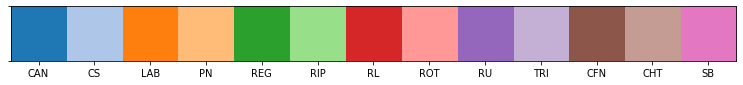

In [24]:
sample_names = aligned_all_neg.cdl.samples
all_labels = aligned_all_neg.cdl.labels
unique_labels = aligned_all_neg.cdl.unique_labels

# customize these colors
colours = sns.color_palette('tab20', 13)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

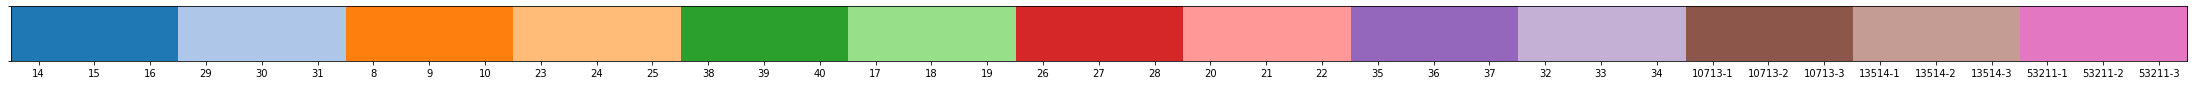

In [25]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations

### Each Dataset is transformed to binary or ...

3/4 types of processing are made:

(Imp (Ionly) - Only Missing Value Imputation).

P - Missing Value Imputation and Pareto Scaling.

NP - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

NGP - Missing Value Imputation, Normalization by reference feature, glog transformation and Pareto Scaling.

In [26]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

def compute_transf(dataset, norm_ref=None, lamb=None):
    intensities = dataset
    dicto = {}
    
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

In [27]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.2771)
print(RefEst_Pos)

(554.26202, 0.0005200000000513683)
(556.2765712820513, 0.0005287179486686)


In [28]:
# Negative mode dataset
treat_neg = compute_transf(aligned_all_neg, norm_ref = 554.26202)

# Positive mode dataset
treat_pos = compute_transf(aligned_all_pos, norm_ref = 556.2765712820513)

## Similarity analysis (Jaccard)

In [29]:
def plot_jaccard_sims(dataset, title=''):
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,

    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    #Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

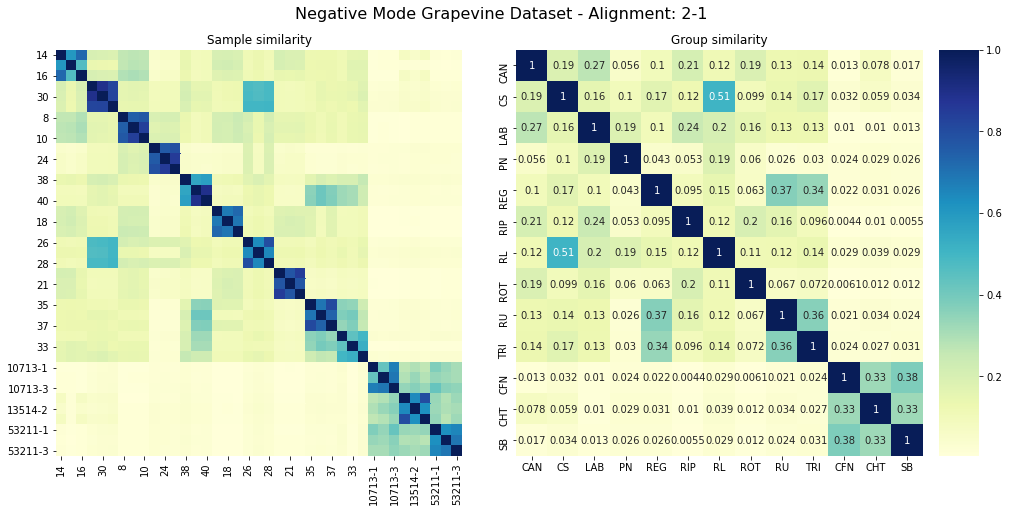

In [30]:
plot_jaccard_sims(aligned_all_neg, 'Negative Mode Grapevine Dataset - Alignment: 2-1')

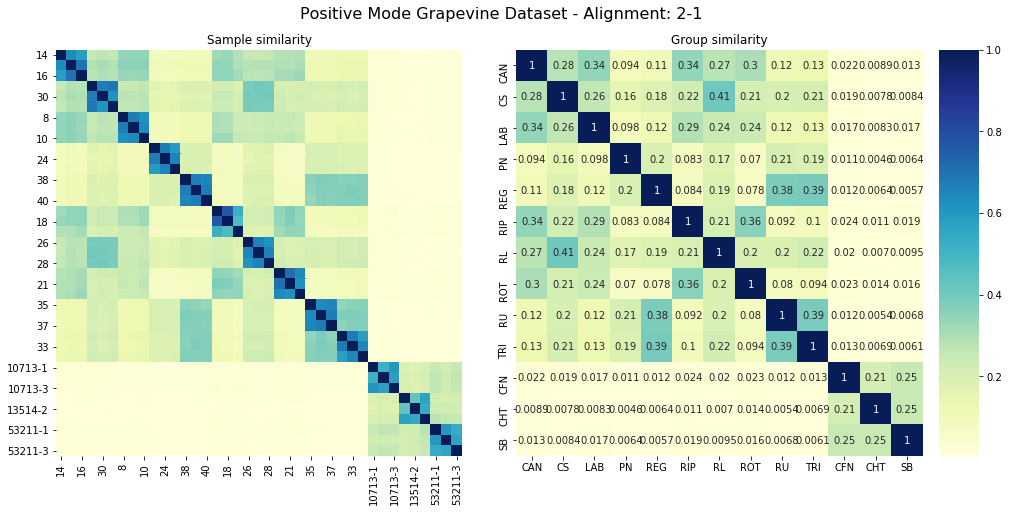

In [31]:
plot_jaccard_sims(aligned_all_pos, 'Positive Mode Grapevine Dataset - Alignment: 2-1')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [32]:
intensities = aligned_all_neg
neg_01 = treat_neg['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_neg.sample_similarity_jaccard
jsim.index.name = 'Sample'
jsim.columns.name = 'Sample'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Dendogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 2-1 (cophenetic = 0.96021)


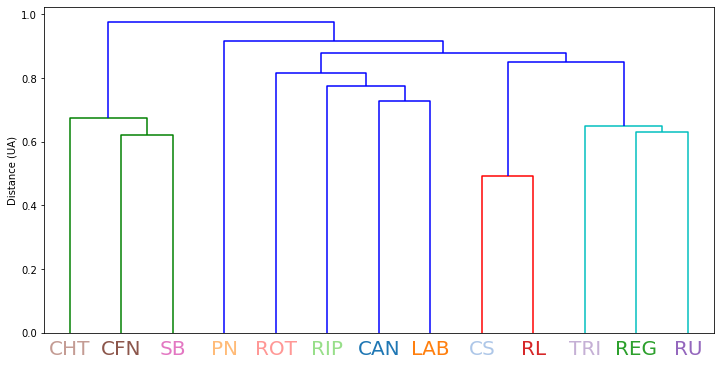

In [33]:
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 2-1 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Dendogram from Jaccard distance, Positive mode Grapevine dataset (cophenetic = 0.96851)


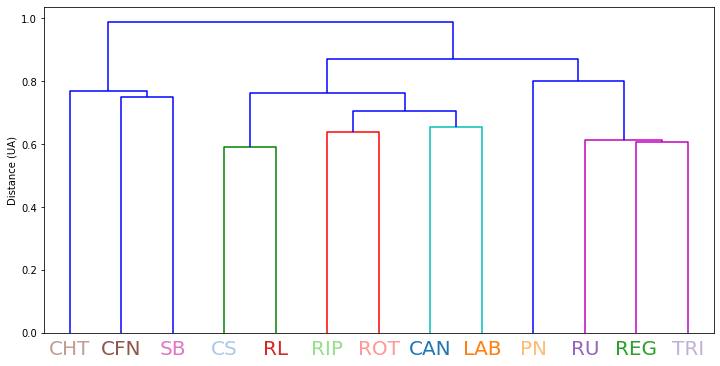

In [34]:
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Positive mode Grapevine dataset (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

## Hierarchical Cluster Analysis (agglomerative)


### Non-binary Similarity Analysis

All samples need to have missing value imputation (removing features is optional) with the function NaN_Imputation of scaling.py (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where 3 different processing methods were applied in different combinations:

##### Normalization by a references feature (Norm_feat from scaling.py) - N;
##### Glog transformation/ log2 transformation (glog from scaling.py) - G;
##### Pareto Scaling (ParetoScal from scaling.py) - P.

In [35]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(16,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=15, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 13)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

### Negative Mode - 2-1 Original Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

Each feature appears at least in 2 samples of the 3 replicates in any of the grapevine varieties. 2_1 in figures.

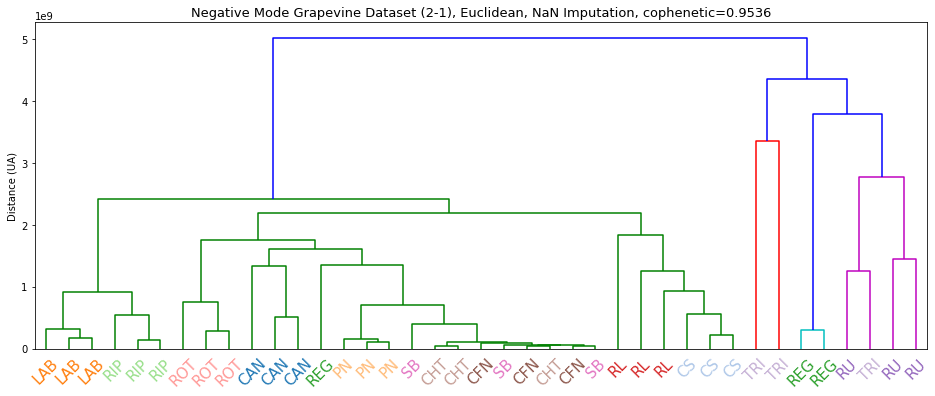

In [36]:
# Missing Value Imputation only
Imp_neg = treat_neg['Ionly']
dist_Imp_neg = dist.pdist(Imp_neg.T, metric = 'euclidean')
Z_Imp_neg = hier.linkage(dist_Imp_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg, dist_Imp_neg)[0]

title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg, title)

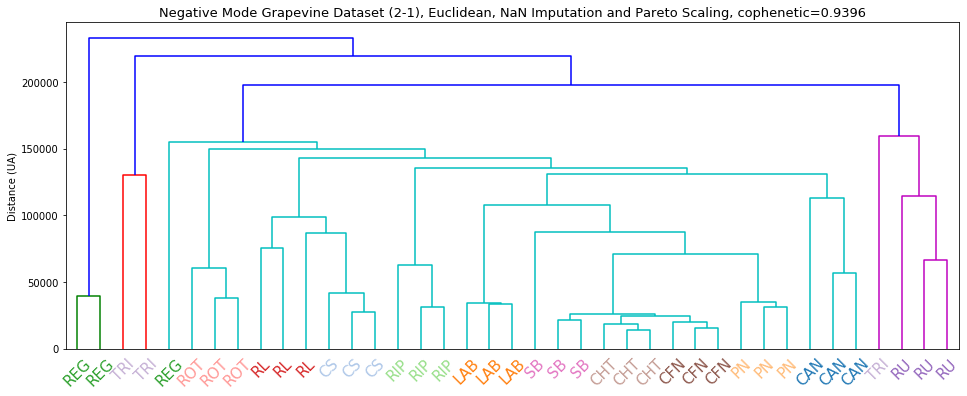

In [37]:
# Imputed and Pareto scaled
P_neg = treat_neg['P']
dist_P_neg = dist.pdist(P_neg.T, metric = 'euclidean')
Z_P_neg = hier.linkage(dist_P_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg, dist_P_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg, title)

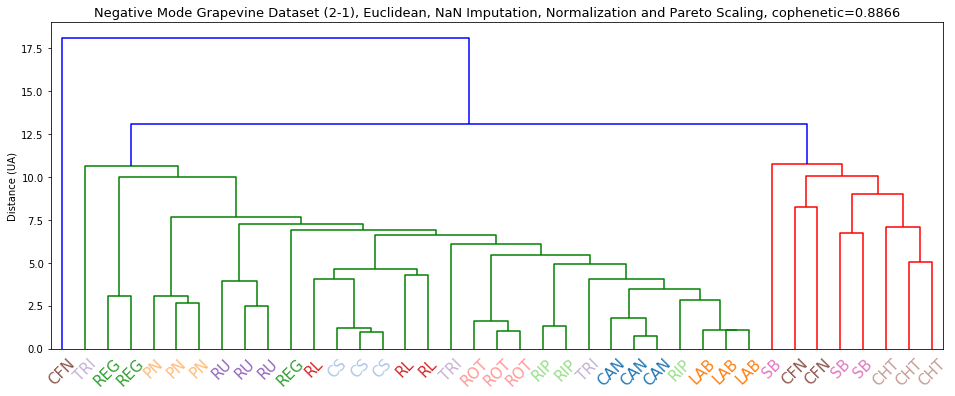

In [38]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_neg = treat_neg['NP']
dist_NP_neg = dist.pdist(NP_neg.T, metric = 'euclidean')
Z_NP_neg = hier.linkage(dist_NP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg, dist_NP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg, title)

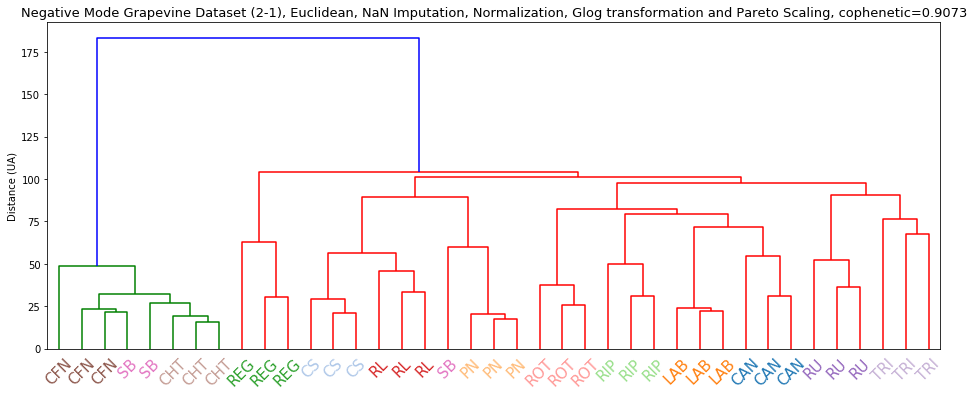

In [39]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_neg = treat_neg['NGP']
dist_NGP_neg = dist.pdist(NGP_neg.T, metric = 'euclidean')
Z_NGP_neg = hier.linkage(dist_NGP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg, dist_NGP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg, title)

#### Binary Similarity Analysis Methods - Example Dendogram

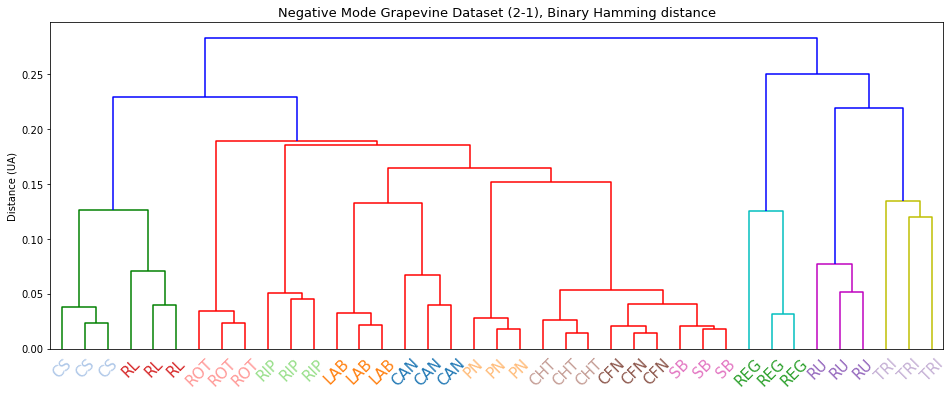

In [40]:
binary = treat_neg['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative Mode Grapevine Dataset (2-1), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Positive Mode - 2-1 Original Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

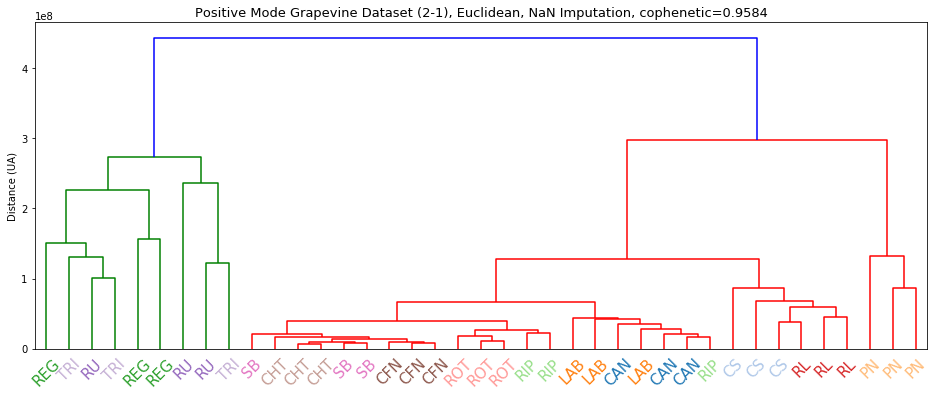

In [41]:
# Missing Value Imputation only
Imp_pos = treat_pos['Ionly']
dist_Imp_pos = dist.pdist(Imp_pos.T, metric = 'euclidean')
Z_Imp_pos = hier.linkage(dist_Imp_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos, dist_Imp_pos)[0]

title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos, title)

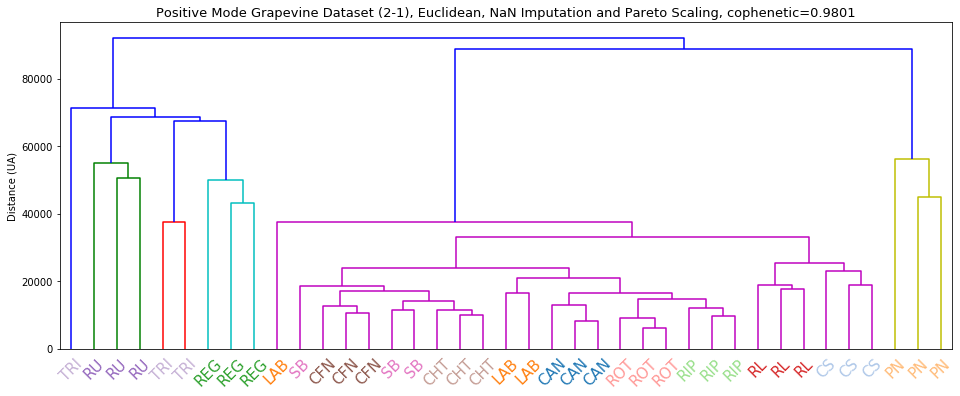

In [42]:
# Imputed and Pareto scaled
P_pos = treat_pos['P']
dist_P_pos = dist.pdist(P_pos.T, metric = 'euclidean')
Z_P_pos = hier.linkage(dist_P_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos, dist_P_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos, title)

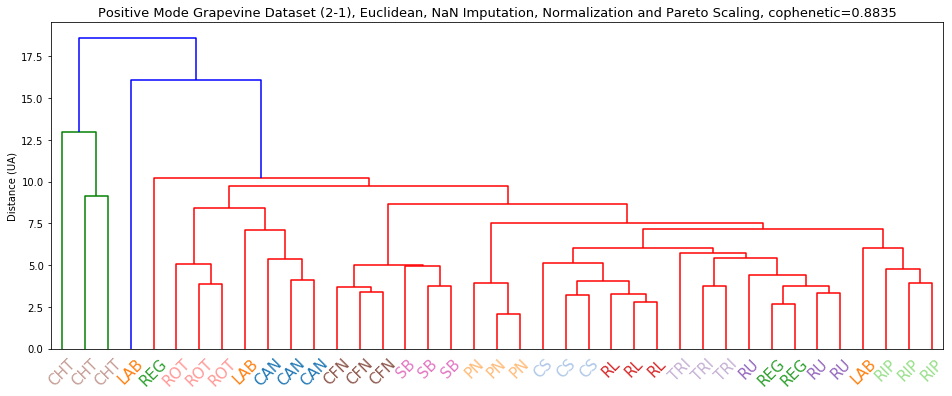

In [43]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_pos = treat_pos['NP']
dist_NP_pos = dist.pdist(NP_pos.T, metric = 'euclidean')
Z_NP_pos = hier.linkage(dist_NP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos, dist_NP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos, title)

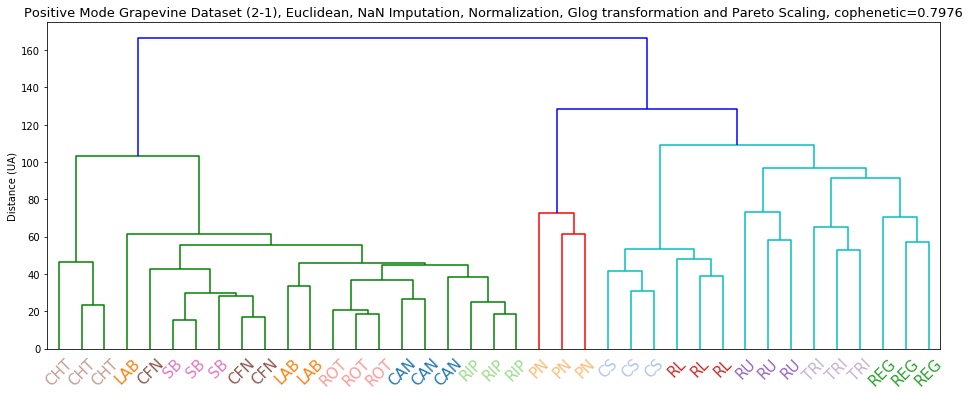

In [44]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_pos = treat_pos['NGP']
dist_NGP_pos = dist.pdist(NGP_pos.T, metric = 'euclidean')
Z_NGP_pos = hier.linkage(dist_NGP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos, dist_NGP_pos)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (2-1), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos, title)

#### Binary Similarity Analysis Methods - Example Dendogram

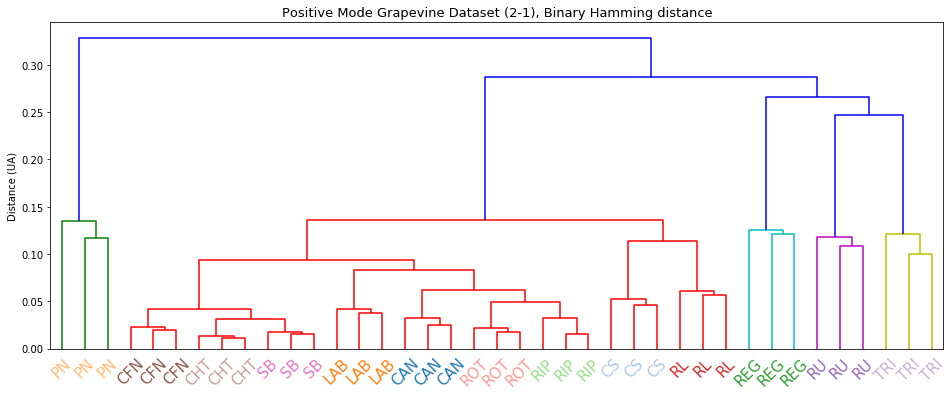

In [45]:
binary = treat_pos['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Positive Mode Grapevine Dataset (2-1), Binary Hamming distance'
plot_dendogram(Zdice, title)

## 2nd Peak Alignment - 3-3

Presented with 2 following the names. Example: treat_neg2.

Same types of processing as before.

### 3-3 alignment 

Each feature appears in at least all replicates of a grapevine variety. Appears as 3_3 in figures.

In [46]:
aligned_all_pos2 = read_aligned_files('aligned_1ppm_min3-3_1ppm_positive.csv')
aligned_all_neg2 = read_aligned_files('aligned_1ppm_min3-3_1ppm_negative.csv')

#### Performing treatments

In [47]:
#Theoretical mass for negative mode Leucine Enkephalin - 554.2615.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg2, 554.2615) #see if the function gives the reference feature
print(RefEst_Neg) #It did!

#Theoretical mass for positive mode Leucine Enkephalin - 556.2771.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos2, 556.2771)
print(RefEst_Pos)

(554.26202, 0.0005200000000513683)
(556.2765712820513, 0.0005287179486686)


In [48]:
# Negative mode dataset
treat_neg2 = compute_transf(aligned_all_neg2, norm_ref = 554.26202)

# Positive mode dataset
treat_pos2 = compute_transf(aligned_all_pos2, norm_ref = 556.2765712820513)

### Negative Mode - 3-3 Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

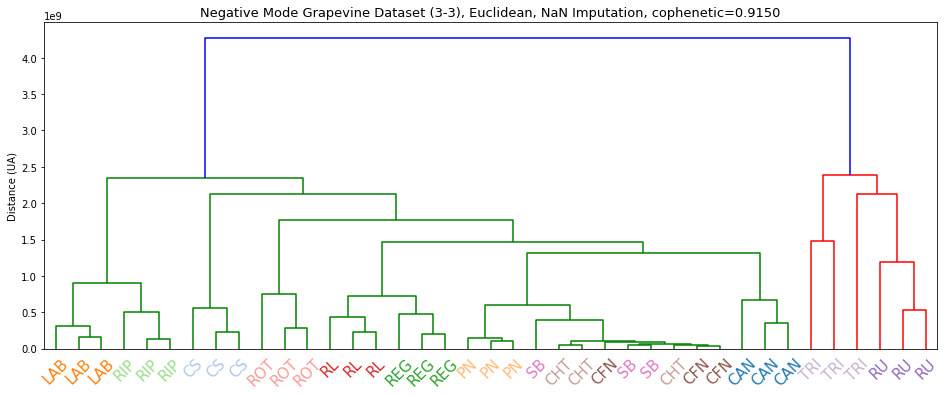

In [49]:
# Missing Value Imputation only
Imp_neg2 = treat_neg2['Ionly']
dist_Imp_neg2 = dist.pdist(Imp_neg2.T, metric = 'euclidean')
Z_Imp_neg2 = hier.linkage(dist_Imp_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg2, dist_Imp_neg2)[0]

title = f'Negative Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg2, title)

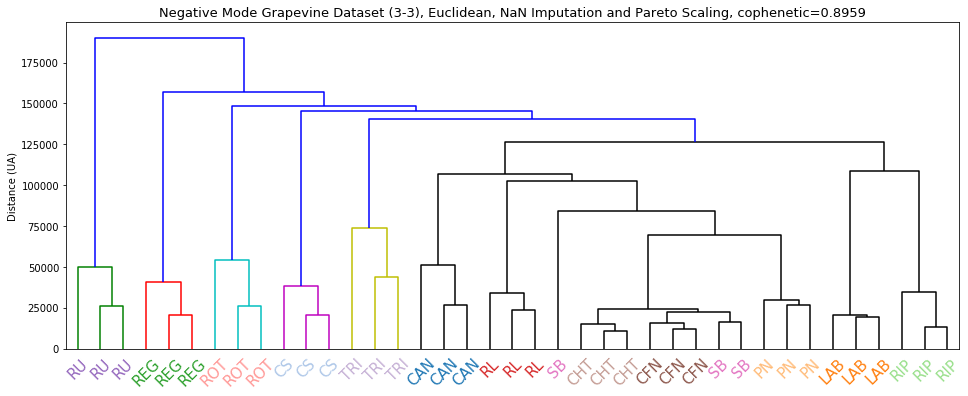

In [50]:
# Imputed and Pareto scaled
P_neg2 = treat_neg2['P']
dist_P_neg2 = dist.pdist(P_neg2.T, metric = 'euclidean')
Z_P_neg2 = hier.linkage(dist_P_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg2, dist_P_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg2, title)

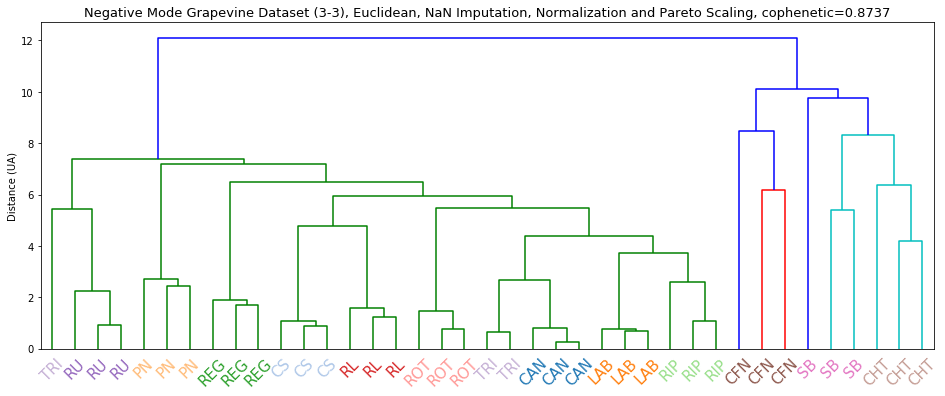

In [51]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_neg2 = treat_neg2['NP']
dist_NP_neg2 = dist.pdist(NP_neg2.T, metric = 'euclidean')
Z_NP_neg2 = hier.linkage(dist_NP_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg2, dist_NP_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg2, title)

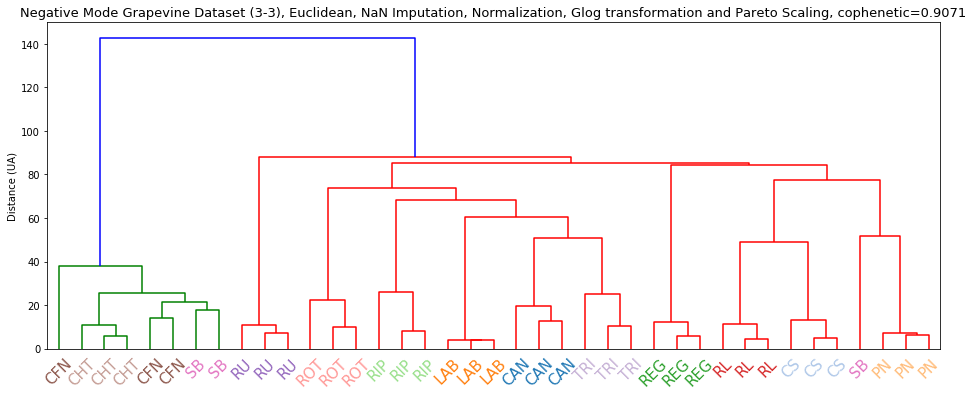

In [52]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_neg2 = treat_neg2['NGP']
dist_NGP_neg2 = dist.pdist(NGP_neg2.T, metric = 'euclidean')
Z_NGP_neg2 = hier.linkage(dist_NGP_neg2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg2, dist_NGP_neg2)[0] #method average seems to lead to higher coefficients
title = f'Negative Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg2, title)

#### Binary Similarity Analysis Methods - Example Dendogram

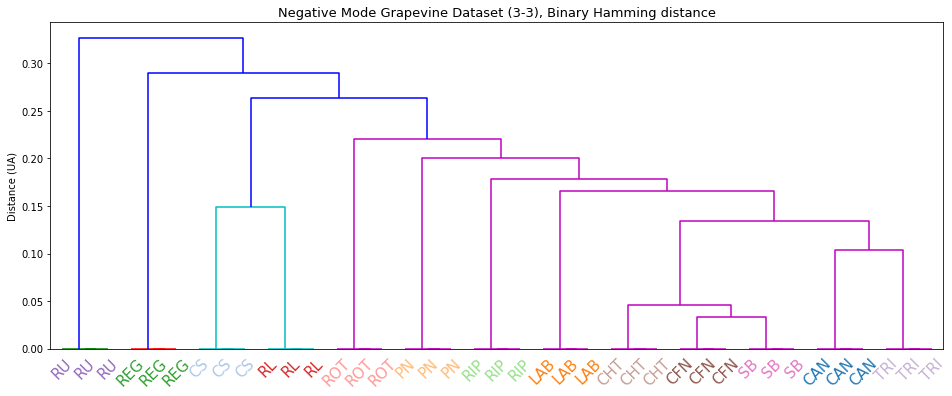

In [53]:
binary = treat_neg2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative Mode Grapevine Dataset (3-3), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Positive Mode - 3-3 Bias Alignment - Dendograms with each differently-treated Grapevine Dataset

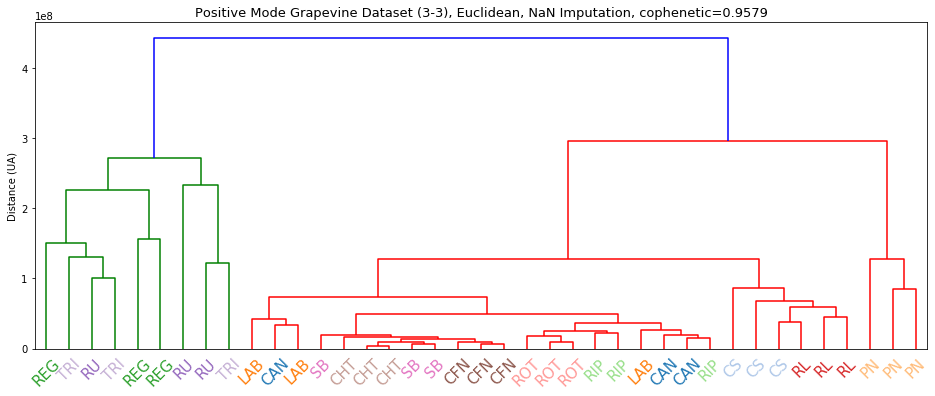

In [54]:
# Missing Value Imputation only
Imp_pos2 = treat_pos2['Ionly']
dist_Imp_pos2 = dist.pdist(Imp_pos2.T, metric = 'euclidean')
Z_Imp_pos2 = hier.linkage(dist_Imp_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_pos2, dist_Imp_pos2)[0]

title = f'Positive Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_pos2, title)

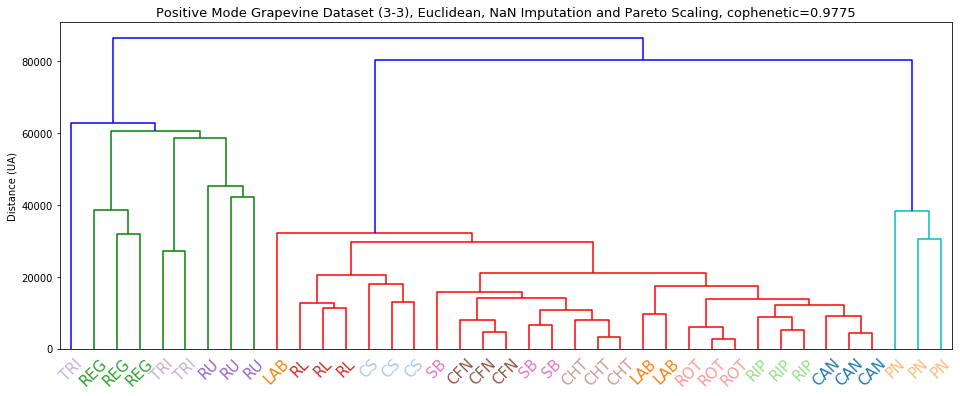

In [55]:
# Imputed and Pareto scaled
P_pos2 = treat_pos2['P']
dist_P_pos2 = dist.pdist(P_pos2.T, metric = 'euclidean')
Z_P_pos2 = hier.linkage(dist_P_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos2, dist_P_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos2, title)

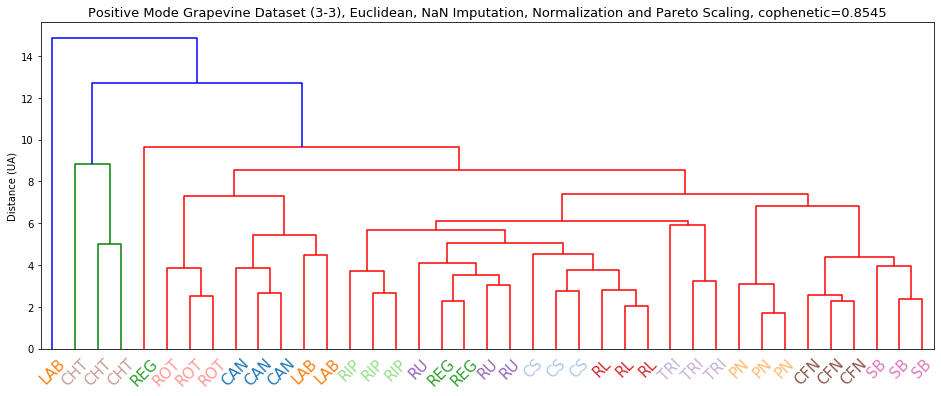

In [56]:
# Imputed, Normalized (reference feature) and Pareto scaled
NP_pos2 = treat_pos2['NP']
dist_NP_pos2 = dist.pdist(NP_pos2.T, metric = 'euclidean')
Z_NP_pos2 = hier.linkage(dist_NP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos2, dist_NP_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, Normalization and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos2, title)

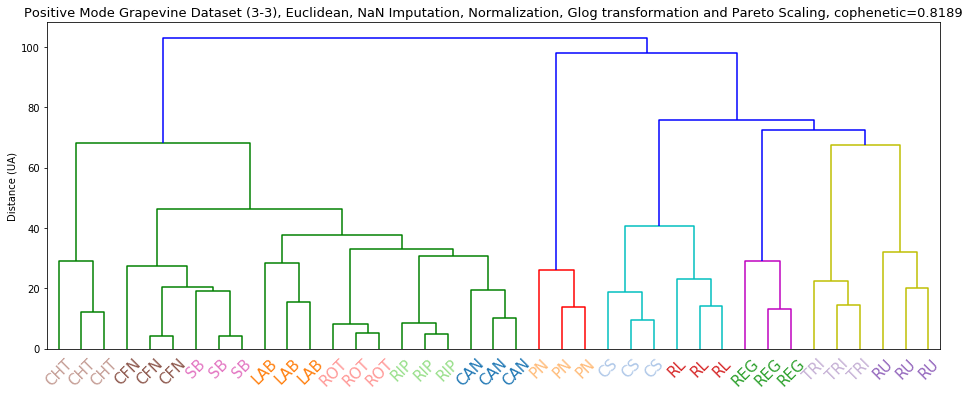

In [57]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
NGP_pos2 = treat_pos2['NGP']
dist_NGP_pos2 = dist.pdist(NGP_pos2.T, metric = 'euclidean')
Z_NGP_pos2 = hier.linkage(dist_NGP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos2, dist_NGP_pos2)[0] #method average seems to lead to higher coefficients
title = f'Positive Mode Grapevine Dataset (3-3), Euclidean, NaN Imputation, Normalization, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos2, title)

#### Binary Similarity Analysis Methods - Example Dendogram

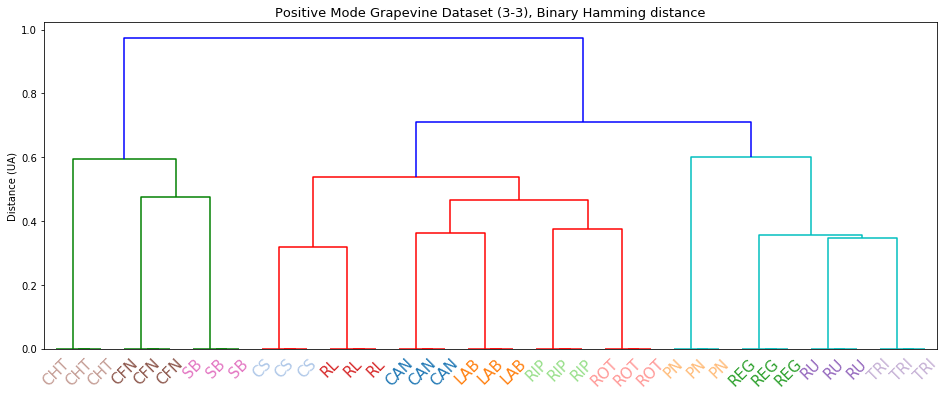

In [58]:
binary = treat_pos2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='dice', method='average')

title = f'Positive Mode Grapevine Dataset (3-3), Binary Hamming distance'
plot_dendogram(Zdice, title)

### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

#### Imp/Ionly not used in this comparison

In [59]:
euclidean = (Z_P_neg, Z_NP_neg, Z_NGP_neg, Z_P_pos, Z_NP_pos, Z_NGP_pos,
            Z_P_neg2, Z_NP_neg2, Z_NGP_neg2, Z_P_pos2, Z_NP_pos2, Z_NGP_pos2)
dist_euclidean = (dist_P_neg, dist_NP_neg, dist_NGP_neg, dist_P_pos, dist_NP_pos, dist_NGP_pos,
                 dist_P_neg2, dist_NP_neg2, dist_NGP_neg2, dist_P_pos2, dist_NP_pos2, dist_NGP_pos2)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(euclidean, dist_euclidean)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [60]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.008910399112678775 	 0.6443850761227088
Euc_P_neg-Euc_NGP_neg	 0.10839742231026103 	 3.835245645295581e-08


According to the explanation given in the R package dendextend

In [61]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 -0.01557548763503229 	 0.5490821254802851
Euc_P_neg-Euc_NGP_neg	 0.12926679353867315 	 5.941307702666646e-07


#### Cophenetic Correlation Coefficient

In [62]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [63]:
print('Pair of samples      \tPearson Correlation \tp-value')
print('Euc_P_neg-Euc_NP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Euc_P_neg-Euc_NGP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Euc_P_neg-Euc_NP_neg	 0.01886183156068998 	 0.6082152998757421
Euc_P_neg-Euc_NGP_neg	 0.16046326918864912 	 1.1381095410638957e-05


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

Change between number of binary metrics to use

In [64]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
#3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
#binary = ( 'jaccard', 'hamming', 'yule')

In [65]:
aligned_neg = treat_neg['binary']
aligned_pos = treat_pos['binary']
aligned_neg2 = treat_neg2['binary']
aligned_pos2 = treat_pos2['binary']

In [66]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg.T, metric = binary[i]))) #Cophenetic

In [67]:
#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_pos.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_pos.T, metric = binary[i]))) #Cophenetic

In [68]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
S = S_BG + S_neg + S_pos

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
Coph = Coph_C + Coph_neg + Coph_pos

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [69]:
#Column names and row names for the dataframes
#3 binary metrics
#colnames = ['P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1',
            #'P_neg3_3', 'NP_neg3_3', 'NGP_neg3_3', 'P_pos3_3', 'NP_pos3_3', 'NGP_pos3_3',
#            'hamming_neg1_6', 'jaccard_neg1_6', 'yule_neg1_6',  'hamming_pos1_6', 'jaccard_pos1_6', 'yule_pos1_6']

#9 binary metrics
colnames = ['P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1','P_neg3_3',
            'NP_neg3_3', 'NGP_neg3_3', 'P_pos3_3', 'NP_pos3_3', 'NGP_pos3_3','dice_neg2_1', 'hamming_neg2_1',
            'jaccard_neg2_1', 'rogerstanimoto_neg2_1', 'sokalmichener_neg2_1', 'sokalsneath_neg2_1','yule_neg2_1', 
            'kulsinski_neg2_1', 'russellrao_neg2_1','dice_pos2_1', 'hamming_pos2_1', 'jaccard_pos2_1', 'rogerstanimoto_pos2_1', 
            'sokalmichener_pos2_1', 'sokalsneath_pos2_1', 'yule_pos2_1', 'kulsinski_pos2_1', 'russellrao_pos2_1']

In [70]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [71]:
#Calculation of correlation coefficient for each method

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,12:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:12], line, df.iloc[12:]])
    prep = pd.concat([prep.iloc[:,:12], lineV.T, prep.iloc[:,12:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


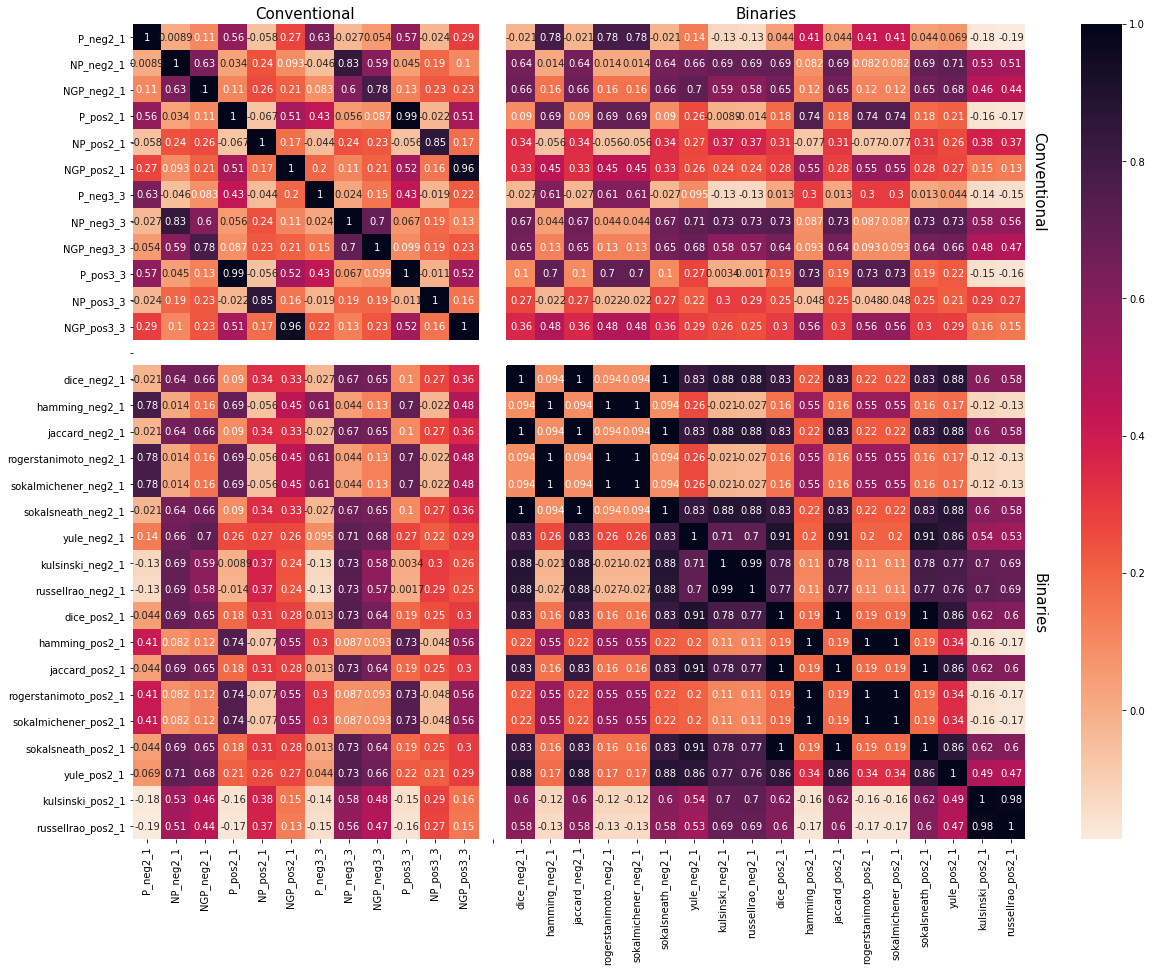

In [72]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

In [73]:
Kendall = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg2_1', 'pos2_1', 'neg3-3', 
                                                                                                'pos3-3', 'neg+pos'))

for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Kendall.iloc[r,j] = df_KI.iloc[13+r,j*3+2]#sum(df_KI.iloc[13+r,j*3:j*3+3])
        elif j in [1,3]:
            Kendall.iloc[r,j] = df_KI.iloc[22+r,j*3+2]#sum(df_KI.iloc[22+r,j*3:j*3+3])
        else:
            Kendall.iloc[r,j] = sum(Kendall.iloc[r,0:4])
#f, ax = plt.subplots(figsize=(5, 4))
#hm = sns.heatmap(Kendall, annot=True, ax=ax, cmap = sns.cm.rocket_r)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.show()
Kendall

neg2_1    pos2_1    neg3-3    pos3-3   neg+pos
dice            0.664713  0.281438  0.651666  0.297424  1.895241
hamming         0.162289  0.552737  0.126805  0.559837  1.401667
jaccard         0.664713  0.281398  0.651666  0.297385  1.895162
rogerstanimoto  0.162289  0.552737  0.126805  0.559837  1.401667
sokalmichener   0.162289  0.552737  0.126805  0.559837  1.401667
sokalsneath     0.664713  0.281398  0.651666  0.297385  1.895162
yule            0.704992  0.268396  0.678266  0.292085  1.943738
kulsinski       0.588243  0.146086  0.577441  0.162257  1.474026
russellrao      0.584614  0.133691  0.573893  0.149361  1.441558

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


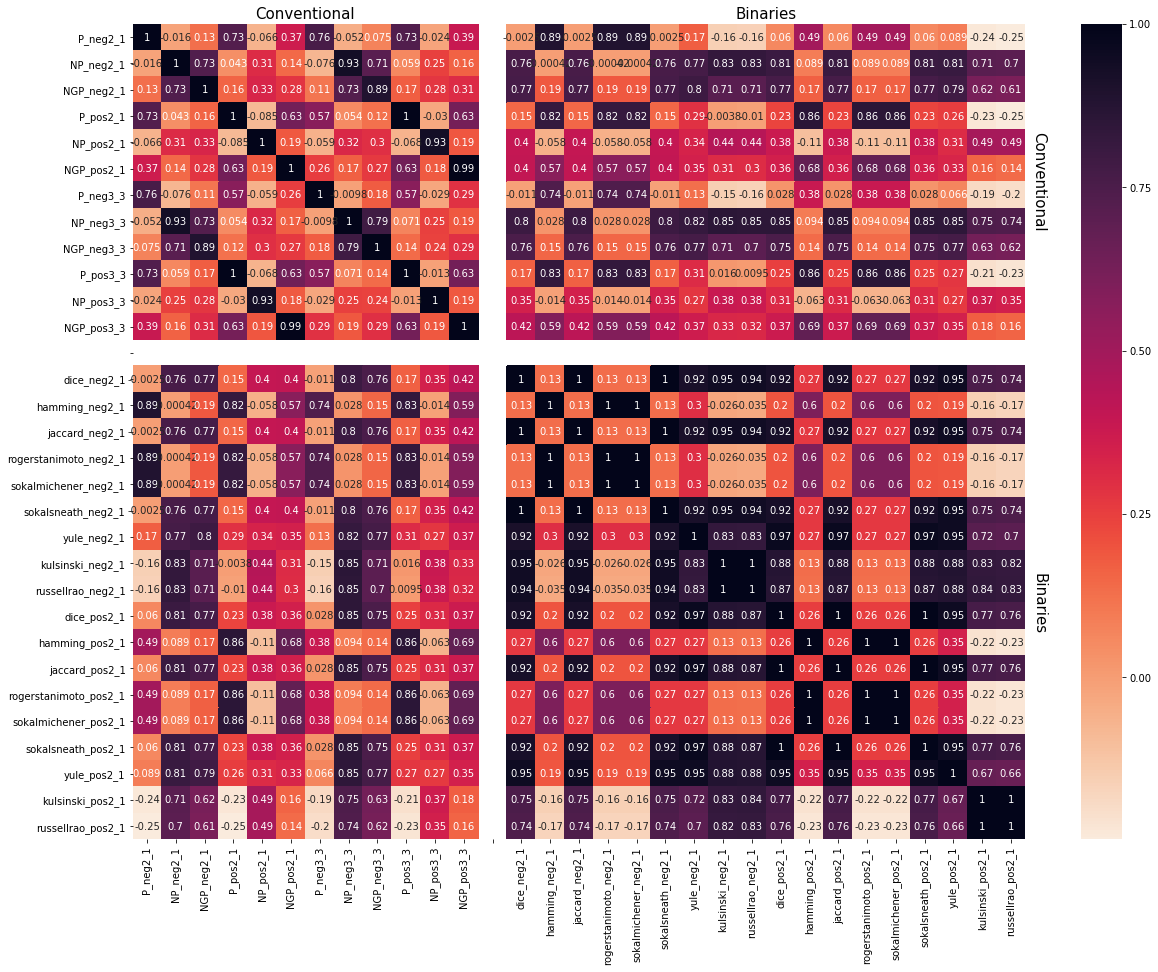

In [74]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


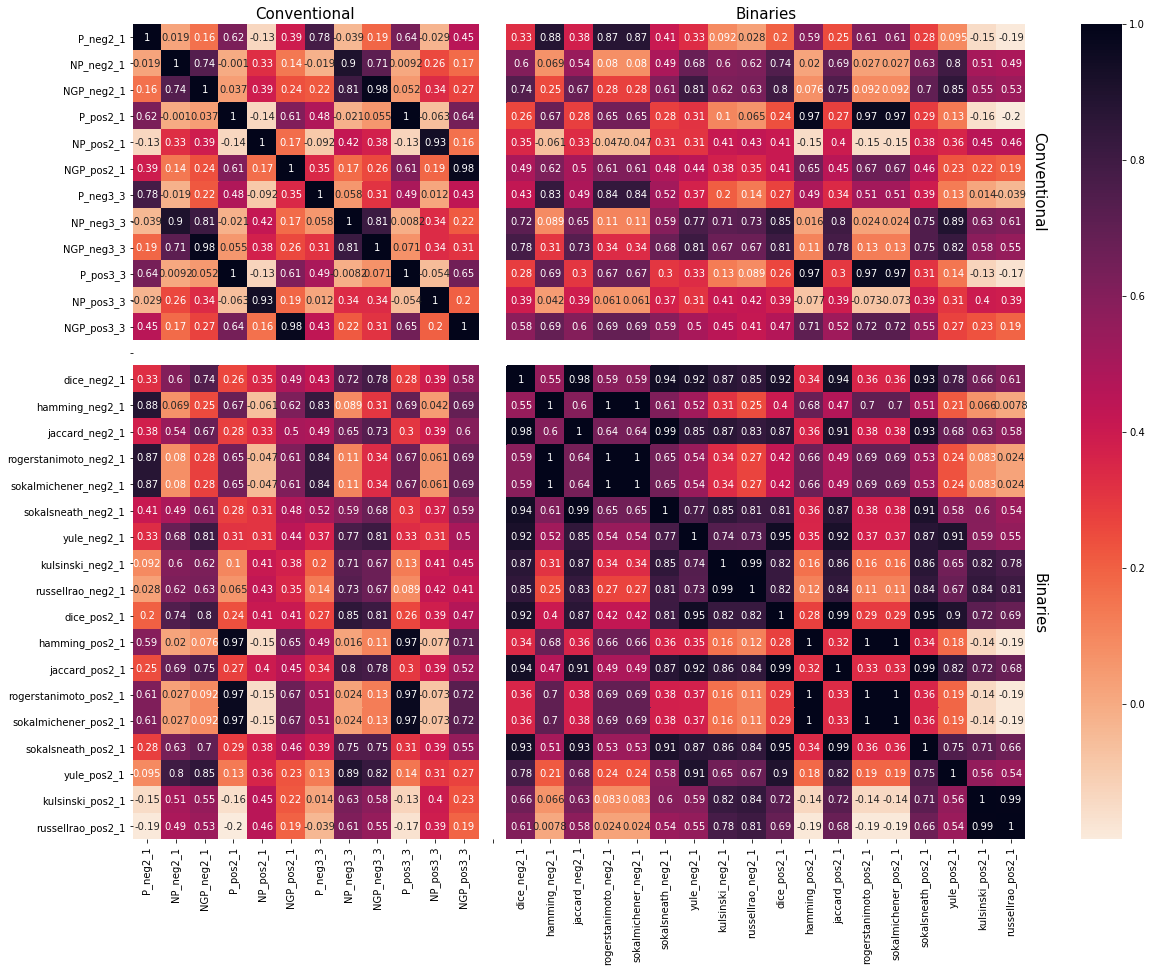

In [75]:
f, ax = plt.subplots(figsize=(20, 15))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

In [76]:
Cophenetic = pd.DataFrame(np.zeros((9, 5)), index = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 
                                                 'yule', 'kulsinski', 'russellrao'), columns = ('neg2_1', 'pos2_1', 'neg3-3', 
                                                                                                'pos3-3','neg+pos'))
for j in range(5):
    for r in range(9):
        if j in [0,2]:
            Cophenetic.iloc[r,j] = df_CI.iloc[13+r,j*3+2]#sum(df_CI.iloc[13+r,j*3:j*3+3])
        elif j in [1,3]:
            Cophenetic.iloc[r,j] = df_CI.iloc[22+r,j*3+2]#sum(df_CI.iloc[22+r,j*3:j*3+3])
        else:
            Cophenetic.iloc[r,j] = sum(Cophenetic.iloc[r,0:4])
Cophenetic

neg2_1    pos2_1    neg3-3    pos3-3   neg+pos
dice            0.740201  0.406479  0.783923  0.466183  2.396787
hamming         0.251433  0.653614  0.306046  0.707337  1.918430
jaccard         0.672143  0.448090  0.731346  0.524247  2.375827
rogerstanimoto  0.277361  0.670985  0.335405  0.724171  2.007922
sokalmichener   0.277361  0.670985  0.335405  0.724171  2.007922
sokalsneath     0.607200  0.464667  0.675879  0.553624  2.301370
yule            0.807353  0.230976  0.810931  0.272794  2.122054
kulsinski       0.623316  0.219444  0.671476  0.234062  1.748298
russellrao      0.631053  0.194345  0.670134  0.191345  1.686876

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: neg_peakalignment1, pos_peakalignment1, neg_peakalignment2, pos_peakalignment2, neg_binary, pos_binary

In [77]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]
for i in range(9):
    label_colors2[colnames[12+i]] = col_lbl2[4]
    label_colors2[colnames[21+i]] = col_lbl2[5]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


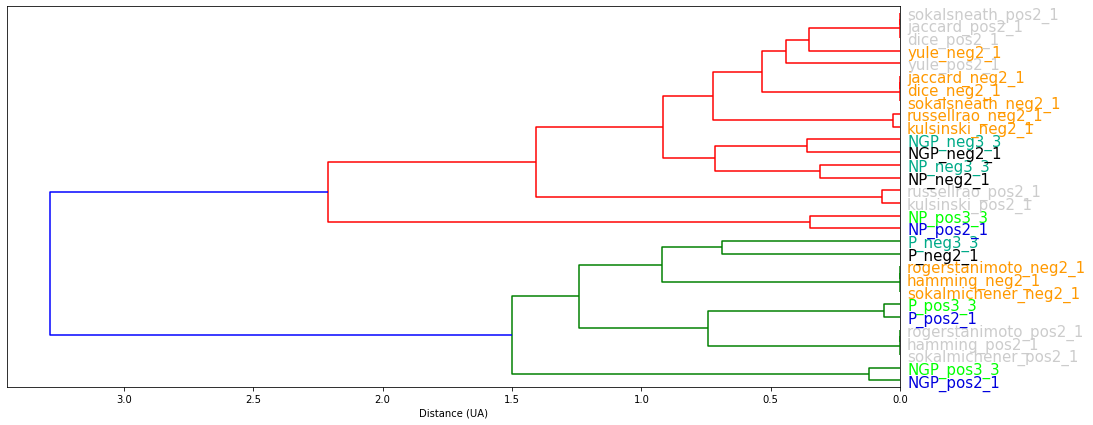

In [78]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


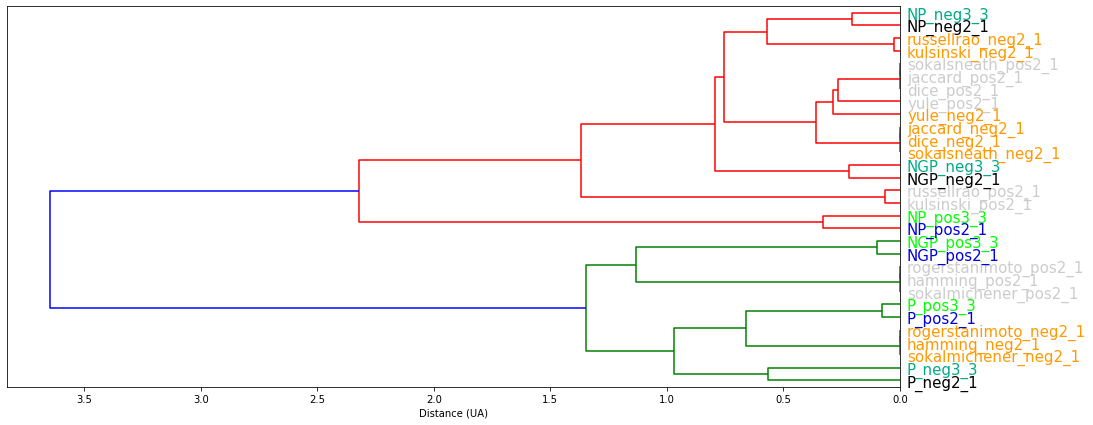

In [79]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_S = hier.linkage(correlations['S'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety
Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety


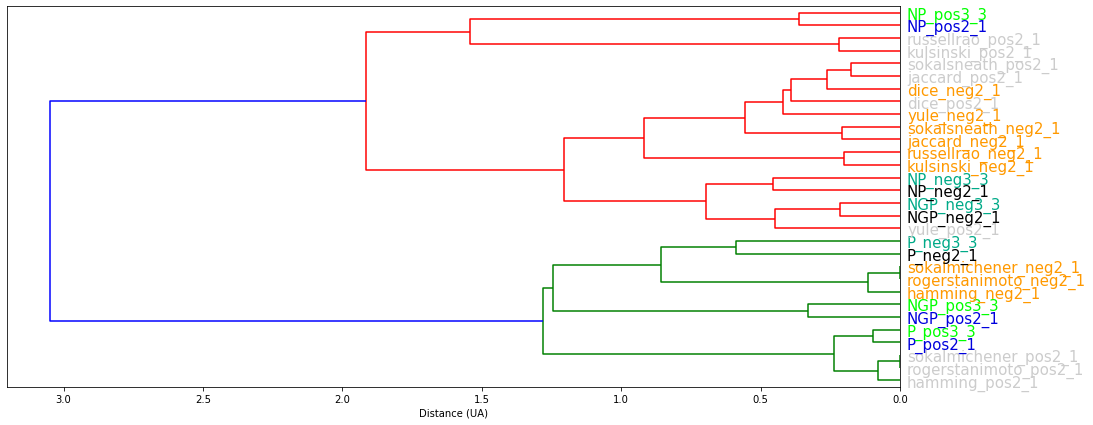

In [80]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('Euc2_1 - Peak alignment requiring that a feature appears in two of the three samples of a certain variety')
print('Euc3_3 - Peak alignment requiring that a feature appears at least once in all samples of a certain variety')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [81]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [82]:
disc_average = np.zeros((1,30))
disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30))
for i in range(len(Z)):
    data = aligned_all_neg
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)

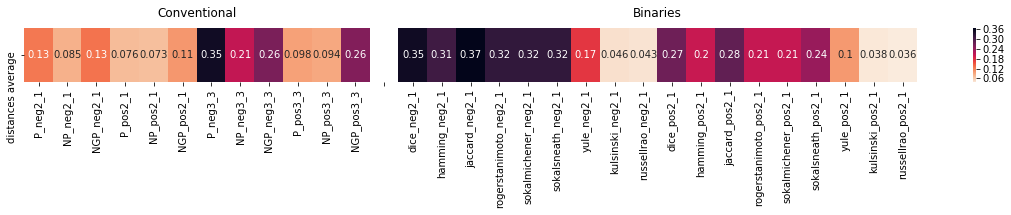

In [83]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(6,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

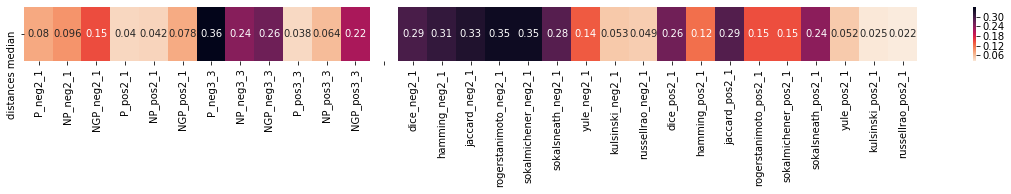

In [84]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

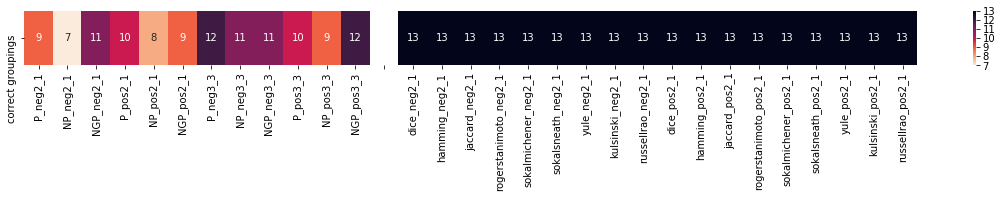

In [85]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [86]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [87]:
Kmean = skclust.KMeans(n_clusters=13)

In [88]:
a = Kmean.fit(NGP_neg.T)

In [89]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{10: ['CAN', 'CAN', 'CAN'],
 9: ['CS', 'CS', 'CS'],
 4: ['LAB', 'LAB', 'LAB'],
 0: ['PN', 'PN', 'PN', 'SB'],
 12: ['REG'],
 5: ['REG', 'REG'],
 2: ['RIP', 'RIP', 'RIP'],
 3: ['RL', 'RL', 'RL'],
 8: ['ROT', 'ROT', 'ROT'],
 6: ['RU', 'RU', 'RU'],
 7: ['TRI', 'TRI'],
 11: ['TRI'],
 1: ['CFN', 'CFN', 'CFN', 'CHT', 'CHT', 'CHT', 'SB', 'SB']}

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the Kmeans_discrim function from multianalysis to calculate discrimination distance.

In [90]:
colnames2 = ['P_neg2_1', 'NP_neg2_1', 'NGP_neg2_1', 'P_pos2_1', 'NP_pos2_1', 'NGP_pos2_1',
             'P_neg3_3', 'NP_neg3_3', 'NGP_neg3_3', 'P_pos3_3', 'NP_pos3_3', 'NGP_pos3_3',
             'binary_neg2_1', 'binary_pos2_1','binary_neg3_3', 'binary_pos3_3']

In [91]:
Data = (P_neg, NP_neg, NGP_neg, P_pos, NP_pos, NGP_pos,
        P_neg2, NP_neg2, NGP_neg2, P_pos2, NP_pos2, NGP_pos2, 
        aligned_neg, aligned_pos, aligned_neg2, aligned_pos2)

In [92]:
disc_average = np.zeros((1,16))
disc_median = np.zeros((1,16))
disc_correct = np.zeros((1,16))
for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(Data[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances average']).T, disc_average.iloc[:,12:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)

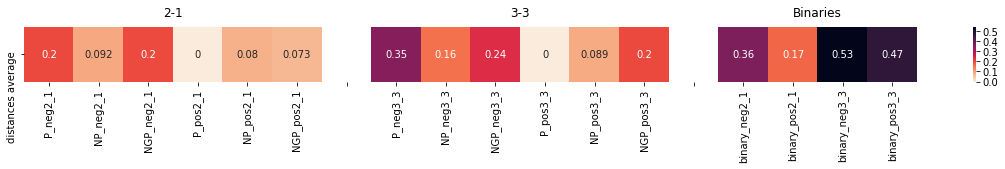

In [93]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'2-1', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'3-3', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

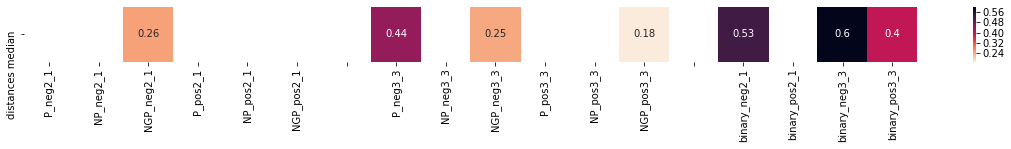

In [94]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

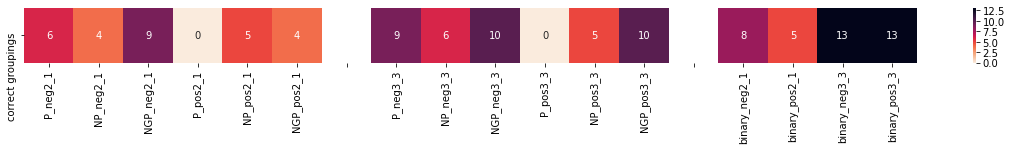

In [95]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 3-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

Grid search of number of trees from 10 to 1000 for the random forests. See where the cross-validation score stops improving for each one.

#### Takes  considerable time

In [96]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,600,10)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [97]:
# Centralize data information in a dictionary
datasets = {}

datasets['I_neg'] = treat_neg['Ionly']
datasets['P_neg'] = treat_neg['P']
datasets['NP_neg'] = treat_neg['NP']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['bin_neg'] = treat_neg['binary']

datasets['I_pos'] = treat_pos['Ionly']
datasets['P_pos'] = treat_pos['P']
datasets['NP_pos'] = treat_pos['NP']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['bin_pos'] = treat_pos['binary']

datasets['I_neg2'] = treat_neg2['Ionly']
datasets['P_neg2'] = treat_neg2['P']
datasets['NP_neg2'] = treat_neg2['NP']
datasets['NGP_neg2'] = treat_neg2['NGP']
datasets['bin_neg2'] = treat_neg2['binary']

datasets['I_pos2'] = treat_pos2['Ionly']
datasets['P_pos2'] = treat_pos2['P']
datasets['NP_pos2'] = treat_pos2['NP']
datasets['NGP_pos2'] = treat_pos2['NGP']
datasets['bin_pos2'] = treat_pos2['binary']

In [98]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting I_neg ... Done!
Fitting P_neg ... Done!
Fitting NP_neg ... Done!
Fitting NGP_neg ... Done!
Fitting bin_neg ... Done!
Fitting I_pos ... Done!
Fitting P_pos ... Done!
Fitting NP_pos ... Done!
Fitting NGP_pos ... Done!
Fitting bin_pos ... Done!
Fitting I_neg2 ... Done!
Fitting P_neg2 ... Done!
Fitting NP_neg2 ... Done!
Fitting NGP_neg2 ... Done!
Fitting bin_neg2 ... Done!
Fitting I_pos2 ... Done!
Fitting P_pos2 ... Done!
Fitting NP_pos2 ... Done!
Fitting NGP_pos2 ... Done!
Fitting bin_pos2 ... Done!


Performance based on number of trees - Alignment: 2-1, Negative Mode


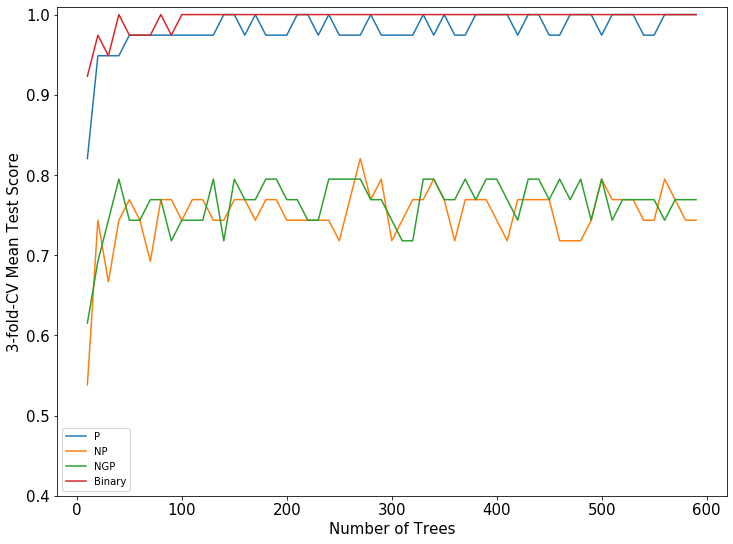

In [99]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(1,5):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 2-1, Negative Mode')

Performance based on number of trees - Alignment: 2-1, Positive Mode


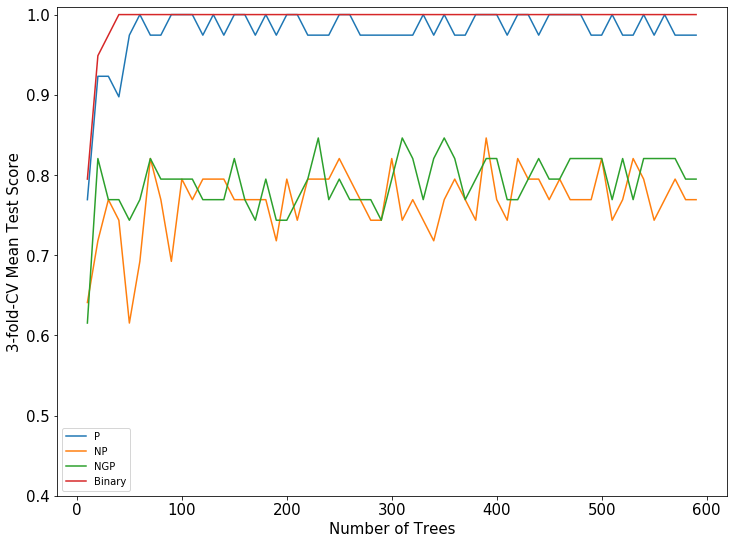

In [100]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(6,10):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 2-1, Positive Mode')

Performance based on number of trees - Alignment: 3-3, Negative Mode


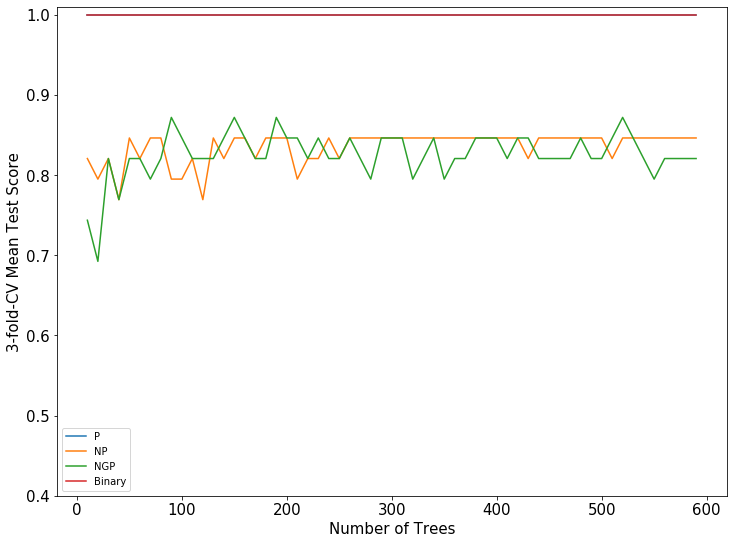

In [101]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(11,15):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 3-3, Negative Mode')

Performance based on number of trees - Alignment: 3-3, Positive Mode


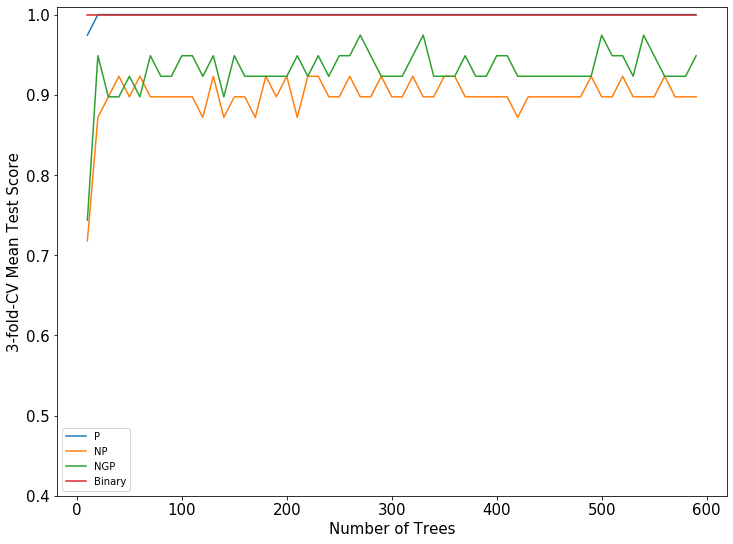

In [102]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(16,20):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 3-3, Positive Mode')

### Performance of N, NP and NGP data treatments (alignments 2-1 and 3-3)

See performance of all 3 treatments and absence of them in non-binary data to see which performs the best using method nº1 (simple application of random forests), see below.

In [103]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [104]:
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data) #, iter_num = 100)
    Teste[name] = rf
    Teste_std[name] = np.std(rf)
    Teste_feat[name] = imp_features
    print(f'done')    

Fitting random forest for I_neg ...done
Fitting random forest for P_neg ...done
Fitting random forest for NP_neg ...done
Fitting random forest for NGP_neg ...done
Fitting random forest for bin_neg ...done
Fitting random forest for I_pos ...done
Fitting random forest for P_pos ...done
Fitting random forest for NP_pos ...done
Fitting random forest for NGP_pos ...done
Fitting random forest for bin_pos ...done
Fitting random forest for I_neg2 ...done
Fitting random forest for P_neg2 ...done
Fitting random forest for NP_neg2 ...done
Fitting random forest for NGP_neg2 ...done
Fitting random forest for bin_neg2 ...done
Fitting random forest for I_pos2 ...done
Fitting random forest for P_pos2 ...done
Fitting random forest for NP_pos2 ...done
Fitting random forest for NGP_pos2 ...done
Fitting random forest for bin_pos2 ...done


Accuracy based on the dataset


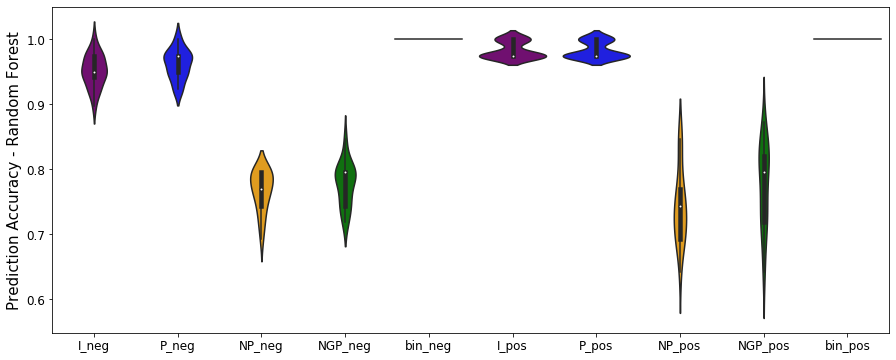

In [105]:
f, ax = plt.subplots(figsize=(15,6))
data = pd.DataFrame.from_dict(Teste)
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data.iloc[:,:10], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

Accuracy based on the dataset


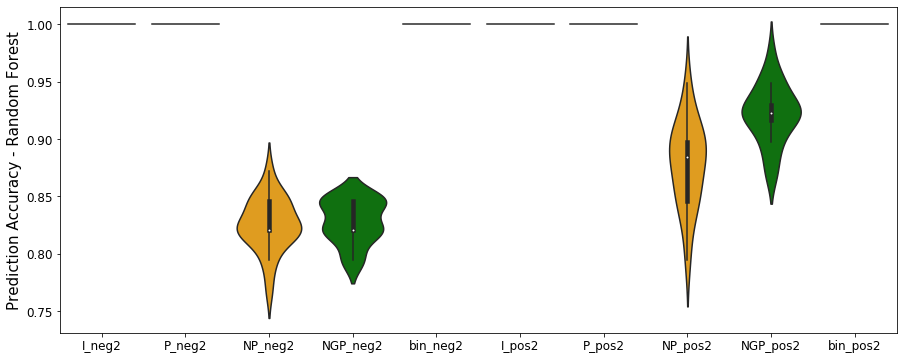

In [106]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['purple','blue','orange','green','red']
sns.violinplot( data = data.iloc[:,10:], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

In [107]:
#Here is median
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.median(Teste[i])

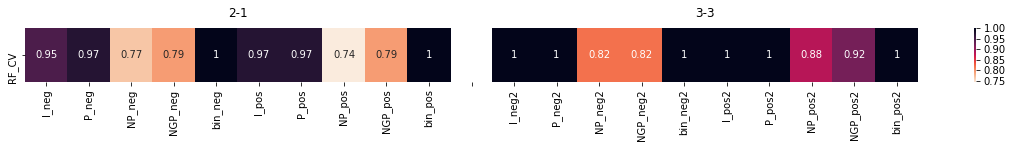

In [108]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Teste_H = pd.concat([Teste_H.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_H.iloc[:,10:]], axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])
plt.text(5,-0.2,'2-1', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'3-3', fontsize  = 12, horizontalalignment='center')
plt.show()

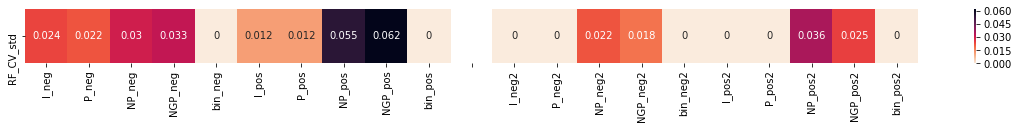

In [109]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Teste_std_H = pd.concat([Teste_std_H.iloc[:,:10], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_std_H.iloc[:,10:]], 
                        axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [110]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Teste_ic = Teste_std_H / (100**0.5)*1.96

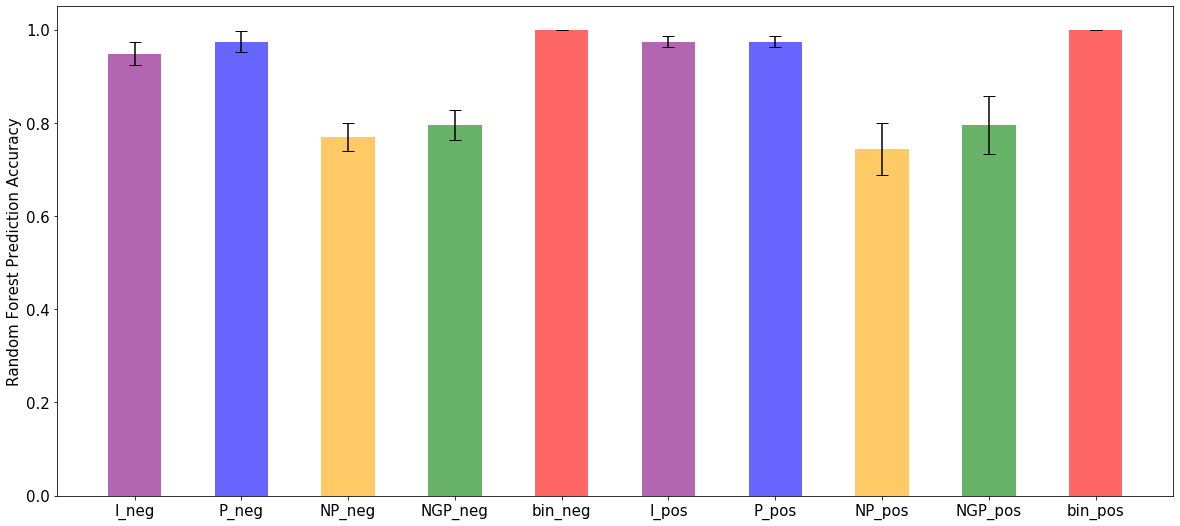

In [111]:
#sns.set_context('notebook')
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][0:10], x = Teste_H.columns[0:10], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[0:10], y = Teste_H.T['Accuracy'][0:10], yerr = Teste_std_H.iloc[0,:10], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show() #This is with median

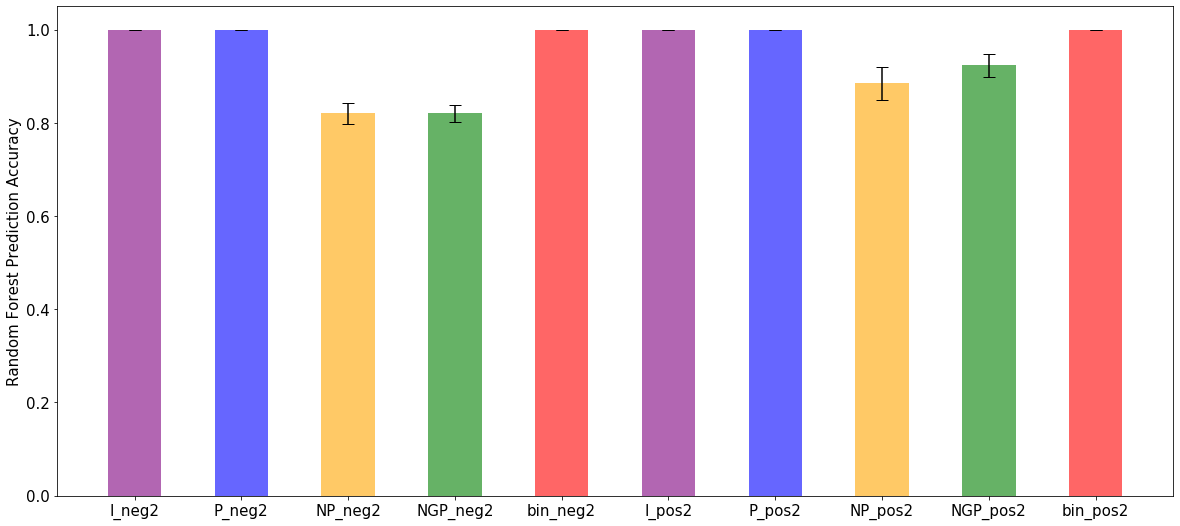

In [112]:
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][10:], x = Teste_H.columns[10:], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[10:], y = Teste_H.T['Accuracy'][10:], yerr = Teste_std_H.iloc[0,10:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.05)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show() #This is with median

#### Applications of different methods

### Attempt/Method nº1 - Direct

### Simple application of random forests

Since the dataset is small, the random forest classification is iterated n times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained - number of random forests can be decided by iter_num. This is the same for all methods. 

To offset the small dataset, 3-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/accuracy (3-fold since that is maximum number possible since every group of samples only has 3 replicates.

Besides the 3-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weigth) is extracted from the forests "built".

Now to run the random forests on the different datasets (negative and positive of both alignments) both in their "normal" and "binary" matrices form. For the normal or euclidean matrices, only the data concerning the P data processing was used since it was the best performer of all former methods employed.

Application of the function `simple_RF` from multianalysis.

In [113]:
#Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

In [114]:
part = {}

part['P_neg'] = treat_neg['P']
part['P_pos'] = treat_pos['P']
part['P_neg2'] = treat_neg2['P']
part['P_pos2'] = treat_pos2['P']
part['bin_neg'] = treat_neg['binary']
part['bin_pos'] = treat_pos['binary']
part['bin_neg2'] = treat_neg2['binary']
part['bin_pos2'] = treat_pos2['binary']

In [115]:
for name, data in part.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data)#, iter_num = 100)
    Scores[name] = np.mean(rf)
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done') 

Fitting random forest for P_neg ...done
Fitting random forest for P_pos ...done
Fitting random forest for P_neg2 ...done
Fitting random forest for P_pos2 ...done
Fitting random forest for bin_neg ...done
Fitting random forest for bin_pos ...done
Fitting random forest for bin_neg2 ...done
Fitting random forest for bin_pos2 ...done


### Attempt/Method nº2 - SMOTE - Code in markdown, not relevant anymore - maybe take out in next version?

### Oversampling data with SMOTE before splitting cross-validation groups. Expected better results due to bleed.

All the same specifications as method nº1 but with an oversampling of the data that doubles the amount of samples (from 39 to 78) which means each cross-valdiation group will have 2 replicates for each variety instead of one.

As mentioned in the title, this means there will be a "bleeding" of the data between test and training groups due to the samples in the test group having been originated from the ones in the training group or have been used to originate data in training groups. Therefore, the score of this method should be higher than the other due to an overestimation of how good the model is due to this bleeding.

SMOTE oversampling is performed in the initial imputated data by the function `fast_SMOTE` from multianalysis.py. 

Therefore we have to run the NGP data processing again for each dataset.

#Neg1
Imp_S_neg = ma.fast_SMOTE(Imputated_neg)
#Norm_S_neg = sca.Norm_Feat(Imp_S_neg, 554.26202)
#glog_S_neg = sca.glog(Norm_S_neg)
Euc_P_S_neg = sca.ParetoScal(Imp_S_neg)#glog_S_neg)
#Neg2
Imp_S_neg2 = ma.fast_SMOTE(Imputated_neg2)
#Norm_S_neg2 = sca.Norm_Feat(Imp_S_neg2, 554.26202)
#glog_S_neg2 = sca.glog(Norm_S_neg2)
Euc_P_S_neg2 = sca.ParetoScal(Imp_S_neg2)#glog_S_neg2)
#Pos1
Imp_S_pos = ma.fast_SMOTE(Imputated_pos)
#Norm_S_pos = sca.Norm_Feat(Imp_S_pos, 556.2765712820513)
#glog_S_pos = sca.glog(Norm_S_pos)
Euc_P_S_pos = sca.ParetoScal(Imp_S_pos)#glog_S_pos)
#Pos2
Imp_S_pos2 = ma.fast_SMOTE(Imputated_pos2)
#Norm_S_pos2 = sca.Norm_Feat(Imp_S_pos2, 556.2765712820513)
#glog_S_pos2 = sca.glog(Norm_S_pos2)
Euc_P_S_pos2 = sca.ParetoScal(Imp_S_pos2)#glog_S_pos2)
#Binaries
binary_S_neg1 = ma.fast_SMOTE(binary_neg1, binary = True)
binary_S_neg2 = ma.fast_SMOTE(binary_neg2, binary = True)
binary_S_pos1 = ma.fast_SMOTE(binary_pos1, binary = True)
binary_S_pos2 = ma.fast_SMOTE(binary_pos2, binary = True)

N1_B = ma.simple_RF(Euc_P_S_neg)
Scores['neg2-1_bleed'] = np.mean(N1_B[0])
Scores_std['neg2-1_bleed'] = np.std(N1_B[0])
Imp_feat['neg2-1_bleed'] = N1_B[1]

P1_B = ma.simple_RF(Euc_P_S_pos)
Scores['pos2-1_bleed'] = np.mean(P1_B[0])
Scores_std['pos2-1_bleed'] = np.std(P1_B[0])
Imp_feat['pos2-1_bleed'] = P1_B[1]

N2_B = ma.simple_RF(Euc_P_S_neg2)
Scores['neg3-3_bleed'] = np.mean(N2_B[0])
Scores_std['neg3-3_bleed'] = np.std(N2_B[0])
Imp_feat['neg3-3_bleed'] = N2_B[1]

P2_B = ma.simple_RF(Euc_P_S_pos2)
Scores['pos3-3_bleed'] = np.mean(P2_B[0])
Scores_std['pos3-3_bleed'] = np.std(P2_B[0])
Imp_feat['pos3-3_bleed'] = P2_B[1]

BN1_B = ma.simple_RF(binary_S_neg1)
Scores['neg2-1_bin_bleed'] = np.mean(BN1_B[0])
Scores_std['neg2-1_bin_bleed'] = np.std(BN1_B[0])
Imp_feat['neg2-1_bin_bleed'] = BN1_B[1]

BP1_B = ma.simple_RF(binary_S_pos1)
Scores['pos2-1_bin_bleed'] = np.mean(BP1_B[0])
Scores_std['pos2-1_bin_bleed'] = np.std(BP1_B[0])
Imp_feat['pos2-1_bin_bleed'] = BP1_B[1]

BN2_B = ma.simple_RF(binary_S_neg2)
Scores['neg3-3_bin_bleed'] = np.mean(BN2_B[0])
Scores_std['neg3-3_bin_bleed'] = np.std(BN2_B[0])
Imp_feat['neg3-3_bin_bleed'] = BN2_B[1]

BP2_B = ma.simple_RF(binary_S_pos2)
Scores['pos3-3_bin_bleed'] = np.mean(BP2_B[0])
Scores_std['pos3-3_bin_bleed'] = np.std(BP2_B[0])
Imp_feat['pos3-3_bin_bleed'] = BP2_B[1]

### Attempt/Method nº3 - Afterproc (Euclidean); Aftersplit (Binary) - Not relevant anymore
Oversampling data with SMOTE after splitting data and after treatment of data (NGP) (binary matrixes don't have any further processing) - Problem: SMOTE after data processing isn't quite the same as in the beginning of the data (vectors between transformed data in different scale than original)

All the same specifications as method nº1.

#### Still possible although probably not very useful, as for now, it won't be implemented in the notebook (method nº4 is the same but completely excised of the notebook.

Application of the function `RF_M3` from multianalysis.

### Results of the Random Forests surmised in Heatmaps

In [116]:
Scores_H = pd.DataFrame(list(Scores.values()), index = Scores.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

#Inserting blank lines in the DataFrame for better presentation and separation
#Scores_H = pd.concat([Scores_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Scores_H.iloc[:,8:]], axis = 1)
#Scores_std_H = pd.concat([Scores_std_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Scores_std_H.iloc[:,8:]], 
                        #axis = 1)

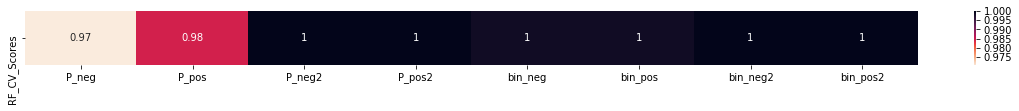

In [117]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])
plt.show()

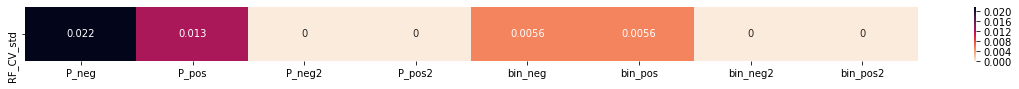

In [118]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Scores_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive) - Still mean, not median

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

### Alignments 2-1 and 3-3 (Bias)

In [119]:
#Getting the number of samples, groups, ratios for each important feature, 
#magnitude for most important feature and calculating % explained by these features (more)
ev = []
magni = []
more = []
for name in Teste_feat:#['neg2-1_direct']:
    if name.endswith('neg'):
        #continue
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        #continue
        Spectra = aligned_all_pos
    elif name.endswith('neg2'):
        #continue
        Spectra = aligned_all_neg2
    elif name.endswith('pos2'):
        #continue
        Spectra = aligned_all_pos2
        
    imp_features = Teste_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra)))
    
    a = 0
    for i in range(number): 
        a = a + imp_features[i][1]*100 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [120]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat]) #if '2-1' in i])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:5], line, df.iloc[5:10], line, df.iloc[10:15], line, df.iloc[15:]])

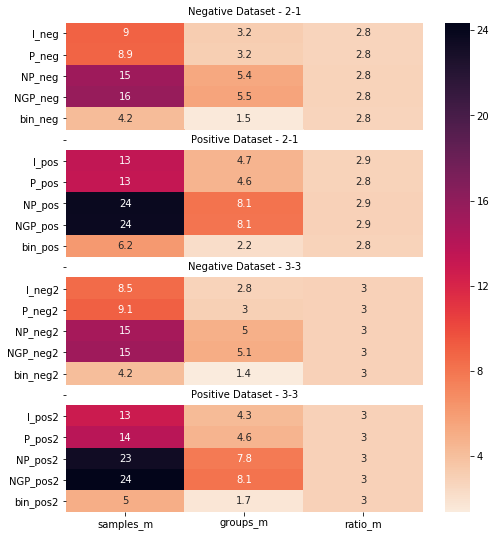

In [121]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Negative Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,5.5,'Positive Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,11.5,'Negative Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,17.5,'Positive Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.show()

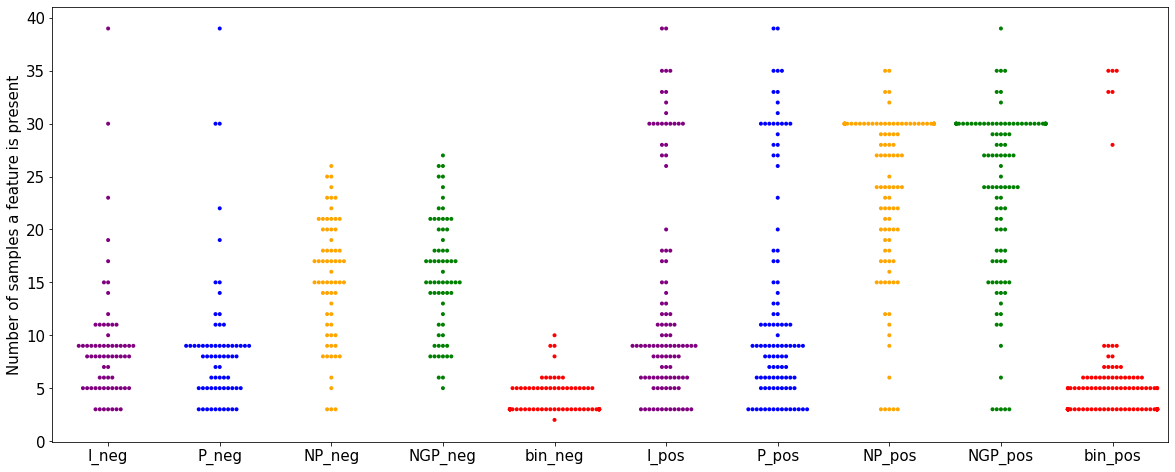

In [122]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[:10], size = 4, palette = ['purple','blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][:10])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

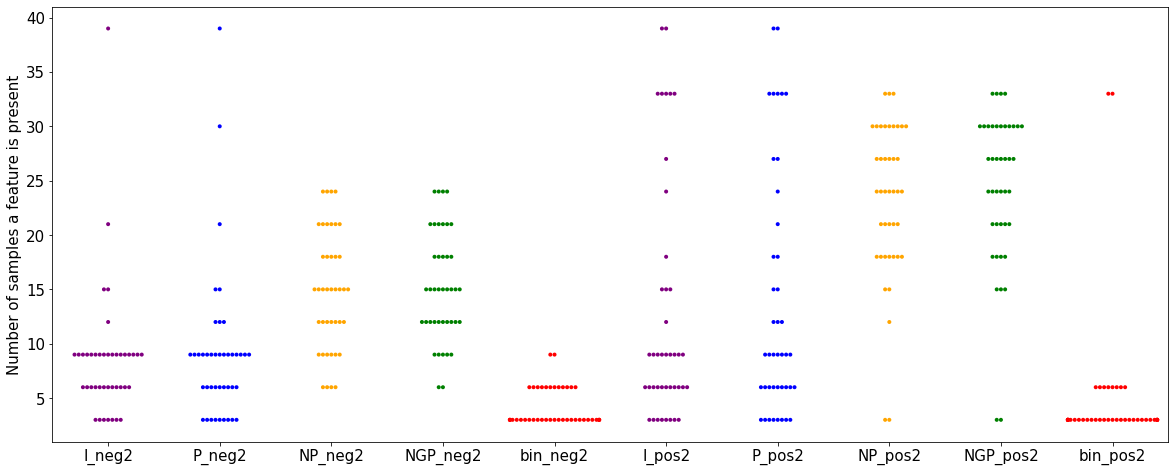

In [123]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[10:], size = 4, palette = ['purple','blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][10:])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [124]:
print('Magnitude of most important feature:', )
for i in range(20):
    print(list(Teste_feat.keys())[i], '     \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(20):
    print(list(Teste_feat.keys())[i], '     \t', more[i])

Magnitude of most important feature:
I_neg      	 5.7068632060960525
P_neg      	 6.261231100097742
NP_neg      	 6.002617974383557
NGP_neg      	 5.356020198394752
bin_neg      	 6.347636697765441
I_pos      	 11.272350005996053
P_pos      	 12.319366632186052
NP_pos      	 5.6588373392131555
NGP_pos      	 6.079980184452582
bin_pos      	 7.691829102586194
I_neg2      	 6.257721897260437
P_neg2      	 6.276991863469665
NP_neg2      	 4.424769674290312
NGP_neg2      	 4.539783334716691
bin_neg2      	 5.338422263226976
I_pos2      	 8.513680569890761
P_pos2      	 9.20694403590492
NP_pos2      	 3.4545842989314623
NGP_pos2      	 3.80053511207862
bin_pos2      	 6.889763852965468


% of model explained by the 2% most important features
I_neg      	 7.81116941391702
P_neg      	 7.827980352233172
NP_neg      	 7.082657590746101
NGP_neg      	 7.125424232672867
bin_neg      	 7.225521223970635
I_pos      	 11.326768324177657
P_pos      	 11.495451246844535
NP_pos      	 8.46863846685366

### Extracting a single decision tree

Decision Tree


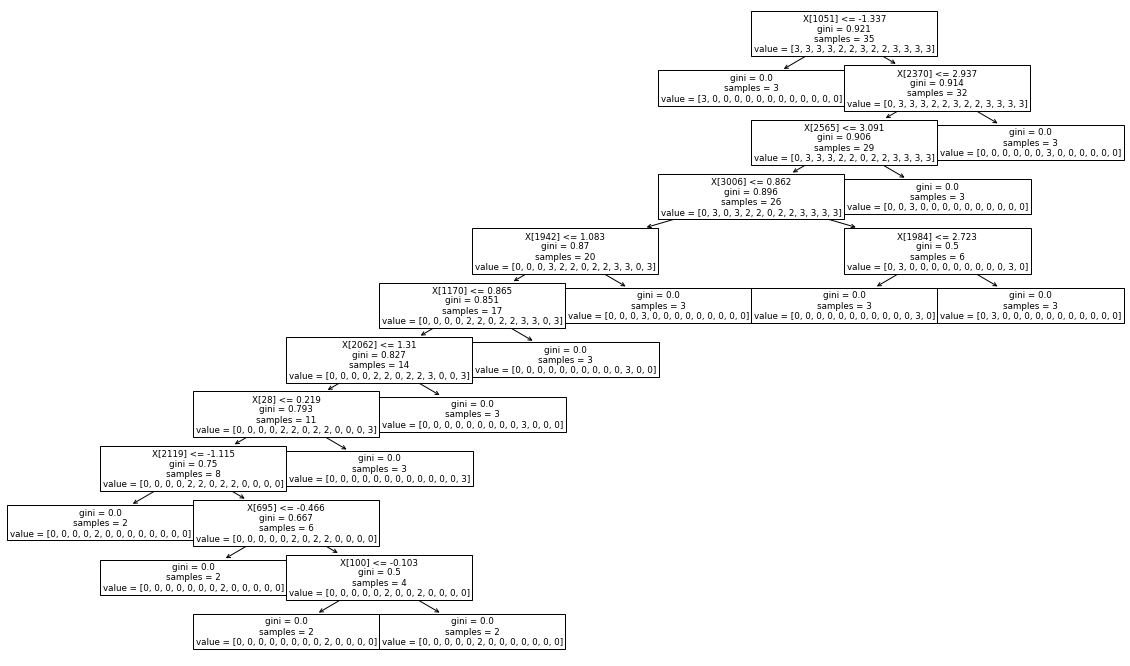

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(NGP_neg.T, NGP_neg.cdl.labels, test_size=0.1)
rf = skensemble.RandomForestClassifier(n_estimators = 200)
rf.fit(X_train, y_train)

from sklearn import tree
fig = plt.figure(figsize=(20,12))
clf = rf.estimators_[2].fit(X_train, y_train)
tree.plot_tree(clf)
print('Decision Tree')

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [126]:
matrix = pd.get_dummies(all_labels)
matrix = matrix[['CAN','CS','LAB','PN','REG','RIP','RL','ROT','RU','TRI','CFN','CHT','SB']]

In [127]:
# Centralize data again excluding the not Imp / Ionly data
datasets = {}

datasets['P_neg'] = treat_neg['P']
datasets['NP_neg'] = treat_neg['NP']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['bin_neg'] = treat_neg['binary']

datasets['P_pos'] = treat_pos['P']
datasets['NP_pos'] = treat_pos['NP']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['bin_pos'] = treat_pos['binary']

datasets['P_neg2'] = treat_neg2['P']
datasets['NP_neg2'] = treat_neg2['NP']
datasets['NGP_neg2'] = treat_neg2['NGP']
datasets['bin_neg2'] = treat_neg2['binary']

datasets['P_pos2'] = treat_pos2['P']
datasets['NP_pos2'] = treat_pos2['NP']
datasets['NGP_pos2'] = treat_pos2['NGP']
datasets['bin_pos2'] = treat_pos2['binary']

### Search for the best number of components to use - Alignment 2-1 and 3-3

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function `optim_PLS` in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [128]:
PLS_optim = {}

In [129]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, matrix, max_comp = 50)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for P_neg ...done
Optimizing PLS-DA for NP_neg ...done
Optimizing PLS-DA for NGP_neg ...done
Optimizing PLS-DA for bin_neg ...done
Optimizing PLS-DA for P_pos ...done
Optimizing PLS-DA for NP_pos ...done
Optimizing PLS-DA for NGP_pos ...done
Optimizing PLS-DA for bin_pos ...done
Optimizing PLS-DA for P_neg2 ...done
Optimizing PLS-DA for NP_neg2 ...done
Optimizing PLS-DA for NGP_neg2 ...done
Optimizing PLS-DA for bin_neg2 ...done
Optimizing PLS-DA for P_pos2 ...done
Optimizing PLS-DA for NP_pos2 ...done
Optimizing PLS-DA for NGP_pos2 ...done
Optimizing PLS-DA for bin_pos2 ...done


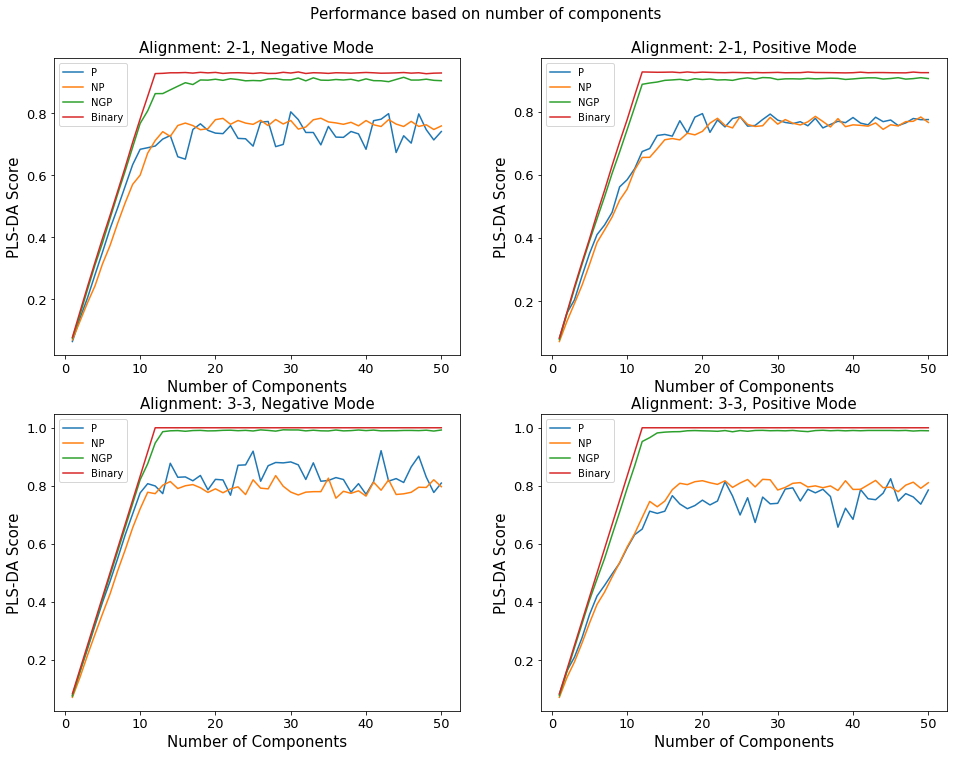

In [130]:
f, axes = plt.subplots(2, 2, figsize = (16,12))
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
plt.suptitle('Performance based on number of components', fontsize = 15, x = 0.5, y = 0.94)

for name, data in PLS_optim.items():
    if name.endswith('neg'):
        quadrant[0].plot(range(1,51),data)
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[0].set_title('Alignment: 2-1, Negative Mode', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('P', 'NP', 'NGP', 'Binary'))
    if name.endswith('pos'):
        quadrant[1].plot(range(1,51),data)
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[1].set_title('Alignment: 2-1, Positive Mode', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('P', 'NP', 'NGP', 'Binary'))
    if name.endswith('neg2'):
        quadrant[2].plot(range(1,51),data)
        quadrant[2].set_xlabel('Number of Components', fontsize=15)
        quadrant[2].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[2].set_title('Alignment: 3-3, Negative Mode', fontsize=15)
        quadrant[2].tick_params(axis='both', which='major', labelsize=13)
        quadrant[2].legend(('P', 'NP', 'NGP', 'Binary'))
    if name.endswith('pos2'):
        quadrant[3].plot(range(1,51),data)
        quadrant[3].set_xlabel('Number of Components', fontsize=15)
        quadrant[3].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[3].set_title('Alignment: 3-3, Positive Mode', fontsize=15)
        quadrant[3].tick_params(axis='both', which='major', labelsize=13)
        quadrant[3].legend(('P', 'NP', 'NGP', 'Binary'))

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better when it reached around 15. Also MSE is the inverse of the score given by the PLS function of the module scikit-learn so from now on we will only collect the score knowing its meaning (equal to explained_variance_score).

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case, a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but, more importantly, the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [131]:
PLS_accu = {}
PLS_score = {}
PLS_VIP = {}
PLS_weights = {}
PLS_RegCoef = {}

The function to apply the PLS-DA is model_PSLDA. As there are many methods to choose the important features that were used to build this model, the following function is built with 3 different methods: VIP or Variable Importance in Projection, the regression coefficient of each variable and the X weights of each variable. Since we are working with a multi-class classification (13 different varieties), this analysis is complicated.

##### Variable Importance in Projection caveats:
There are some potential issues with the calculation of the VIP score for each variable that is employed here due to my limited knowledge of this methodology:

1) Although I can understand the equation that is being translated into Python code in the_calculate_vips function in multianalysis.py, I don't understand where in the equation that is presented in many different articles it is shown that you only take the diagonal values of the weight of a variable in a component / weights of all variables in that component despite it being essential in the equation (so it doesn't give an error back).

2) Alterations regarding Y variance that are needed specifically for multi-y cases such as this (multi-class) in calculating variable importance may not have been made on the calculations.

3) q^2 * t' * t (y_loadings squared times the transposed x_scores_ matrix times the x_scores matrix) should give the explained variance of the model for each component however by adding all of the explained variances you can get values over 100 % by substantial margins.

##### Regression Coefficients and X Weights caveats:

These methods are quite simple to apply - simply see the absolute values of each variable in both cases where a bigger absolute value would mean a greater importance. However, there is still a problem since methods like these are usually used in PLS-DA with only two classes in the literature. In multi-class cases like this one, there is a regression coefficient or an x_weight for each y (each class). Therefore to see the overall importance of the variables the absolute values were summed together for every sample and then ordered (there is no fallback to literature as of yet).

Taking this into account, it is also worth mentioning that these two methods aren't only considerably simpler than VIP scores but also much less computationally expensive. To see if we can use this simpler methods instead of the attempt at VIP scores that is being made, we will then see how many common important features the methods have among themselves (by seeing the number of repeating features in the 2% of most important features as categorized by each method).

In [132]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

In [133]:
def model_PLSDA(Spectra, matrix, n_comp, n_fold = 3, iter_num = 1, figures = False):
    """Perform PLS-DA on an AlignedSpectra with 3-fold cross-validation and obtain the model's accuracy and important features.

       Spectra: AlignedSpectra object (from metabolinks); includes X equivalent in PLS-DA (training vectors).
       matrix: pandas DataFrame; y equivalent in PLS-DA (target vectors).
       n_comp: integer; number of components to use in PLS-DA.
       n_fold: int (default - 3); number of groups to divide dataset in for k-fold cross-validation (max n_fold = minimum number of
    samples belonging to one group).
    iter_num: int (default - 1); number of iterations that PLS-DA is repeated.
       figures: bool/int (default: False); if an integer n, shows distribution of samples of n groups in 3 scatter plots with the 2 most
    important latent variables (components) - one for each group of cross-validation.

       Returns: (list, list, list, list of tuples, list of tuples, list of tuples); accuracy in group selection, 3-fold 
    cross-validation score, r2 score of the model, descending ordered list of tuples with index number of feature, feature 
    importance and name of feature for VIP, Weights and Regression Coefficient respectively.
    """
    #Setting up lists and matrices to store results
    CV = []
    CVR2 = []
    Accuracy = []
    VIP = np.zeros((iter_num*n_fold, len(Spectra)))
    Weights = np.zeros((iter_num*n_fold, len(Spectra)))
    RegCoef = np.zeros((iter_num*n_fold, len(Spectra)))
    f = 0

    #Number of iterations equal to iter_num
    for i in range(iter_num):
        #Splitting data into 3 groups for 3-fold cross-validation
        kf = StratifiedKFold(3, shuffle = True)
        #Setting up variables for results of the application of 3-fold cross-validated PLS-DA
        certo = 0
        cv = []
        cvr2 = []

        #Repeating for each of the 3 groups
        for train_index, test_index in kf.split(Spectra.T, Spectra.cdl.labels):
            plsda = PLSRegression(n_components = n_comp)
            X_train, X_test = Spectra[Spectra.columns[train_index]].T, Spectra[Spectra.columns[test_index]].T
            y_train, y_test = matrix.T[matrix.T.columns[train_index]].T, matrix.T[matrix.T.columns[test_index]].T
            #Fitting the model
            plsda.fit(X=X_train,Y=y_train)

            #Obtaining results with the test group
            cv.append(plsda.score(X_test,y_test))
            cvr2.append(r2_score(plsda.predict(X_test), y_test))
            y_pred = plsda.predict(X_test)

            #Decision to which group each sample belongs to based on y_pred
            #Decision rule chosen: sample belongs to group where it has max y_pred (closer to 1)
            for i in range(len(y_pred)):
                #if list(y_test[i]).index(max(y_test[i])) == np.argmax(y_pred[i]):
                if list(y_test.iloc[:,i]).index(max(y_test.iloc[:,i])) == np.argmax(y_pred[i]):
                    certo = certo + 1 #Correct prediction
            
            #Calculating important features by 1 of 3 different methods
            VIP[f,:] = ma._calculate_vips(plsda)
            Weights[f,:] = abs(plsda.x_weights_).sum(axis = 1)
            RegCoef[f,:] = abs(plsda.coef_).sum(axis = 1)
            f = f + 1

            #figures = True - making scatter plots of training data in the 2 first components
            LV_score = pd.DataFrame(plsda.x_scores_)

            if figures != False:
                #Preparing colours to separate different groups
                colours = cm.get_cmap('nipy_spectral', figures)
                col_lbl = colours(range(figures))
                col_lbl = list(col_lbl)
                for i in range(len(col_lbl)):
                    a = 2*i
                    col_lbl.insert(a+1,col_lbl[a])

                #Scatter plot
                ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
                #Labeling each point
                i = -1
                for n, x in enumerate(LV_score.values): 
                    if n%2 == 0:
                        i = i + 1
                    label = Spectra.cdl.unique_labels()[i]
                    #label = LV_score.index.values[n]
                    ax.text(x[0],x[1],label, fontsize = 8)


        #Calculating the accuracy of the group predicted and storing score results
        Accuracy.append(certo/len(Spectra.cdl.labels))
        CV.append(np.mean(cv))
        CVR2.append(np.mean(cvr2))
        
    #Joining and ordering all important features values from each cross validation group and iteration for each method.
    VIP_sum = VIP.sum(axis = 0)/(iter_num*n_fold)
    VIP_sum = sorted(enumerate(VIP_sum), key = lambda x: x[1], reverse = True)
    VIP_ord = []
    for i,j in VIP_sum:
        VIP_ord.append((i , j, Spectra.index[i]))
        
    Weights_sum = Weights.sum(axis = 0)/(iter_num*n_fold)
    Weights_sum = sorted(enumerate(Weights_sum), key = lambda x: x[1], reverse = True)
    Weights_ord = []
    for i,j in Weights_sum:
        Weights_ord.append((i , j, Spectra.index[i]))
        
    RegCoef_sum = RegCoef.sum(axis = 0)/(iter_num*n_fold)
    RegCoef_sum = sorted(enumerate(RegCoef_sum), key = lambda x: x[1], reverse = True)
    RegCoef_ord = []
    for i,j in RegCoef_sum:
        RegCoef_ord.append((i , j, Spectra.index[i]))
    
    return Accuracy, CV, CVR2, Weights_ord, RegCoef_ord, VIP_ord

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better when it reached around 15. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [134]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, weights, RegCoef, VIP = model_PLSDA(data, matrix, n_comp = 15, iter_num = 100)
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_weights[name] = weights
    PLS_RegCoef[name] = RegCoef
    PLS_VIP[name] = VIP
    print(f'done')    

Fitting PLS-DA for P_neg ...done
Fitting PLS-DA for NP_neg ...done
Fitting PLS-DA for NGP_neg ...done
Fitting PLS-DA for bin_neg ...done
Fitting PLS-DA for P_pos ...done
Fitting PLS-DA for NP_pos ...done
Fitting PLS-DA for NGP_pos ...done
Fitting PLS-DA for bin_pos ...done
Fitting PLS-DA for P_neg2 ...done
Fitting PLS-DA for NP_neg2 ...done
Fitting PLS-DA for NGP_neg2 ...done
Fitting PLS-DA for bin_neg2 ...done
Fitting PLS-DA for P_pos2 ...done
Fitting PLS-DA for NP_pos2 ...done
Fitting PLS-DA for NGP_pos2 ...done
Fitting PLS-DA for bin_pos2 ...done


### Alignment 2-1

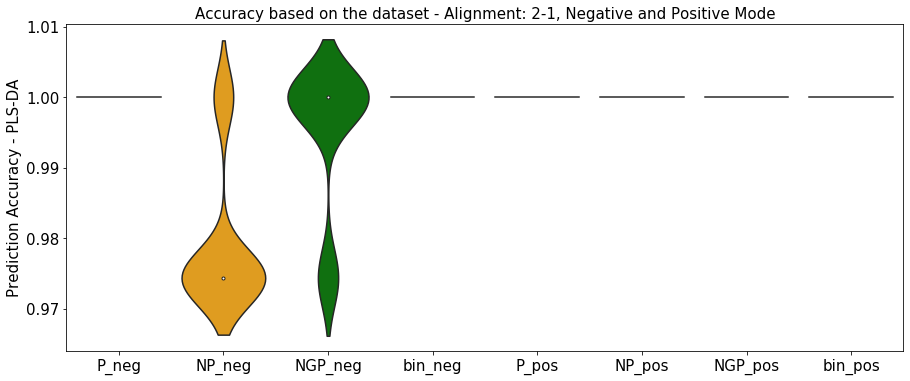

In [135]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,:8]
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
plt.title('Accuracy based on the dataset - Alignment: 2-1, Negative and Positive Mode', fontsize = 15)
plt.show()

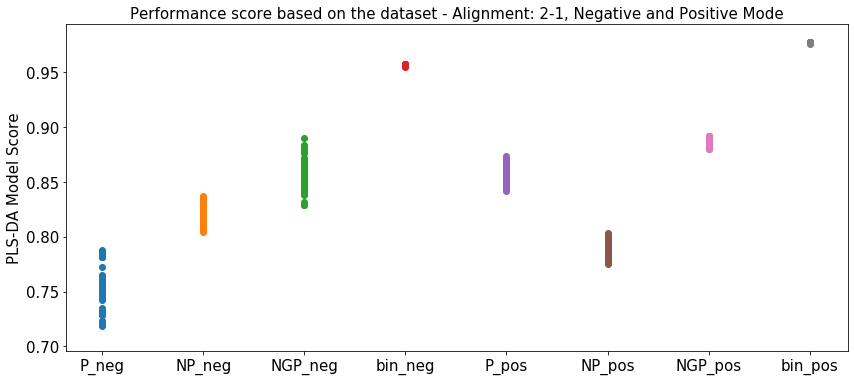

In [136]:
f, ax = plt.subplots(figsize=(14,6))
for name, data in PLS_score.items():
    if not name.endswith('2'):
        plt.scatter([name]*len(data), data)
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Performance score based on the dataset - Alignment: 2-1, Negative and Positive Mode', fontsize = 15)
plt.show()

### Alignment 3-3

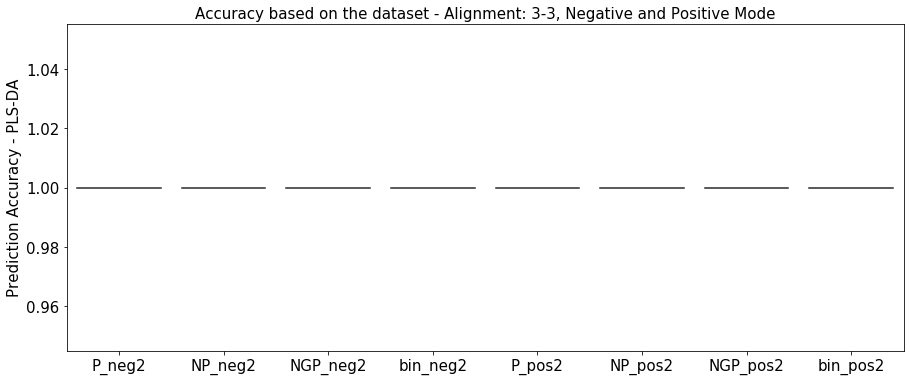

In [137]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,8:]
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
plt.title('Accuracy based on the dataset - Alignment: 3-3, Negative and Positive Mode', fontsize = 15)
plt.show()

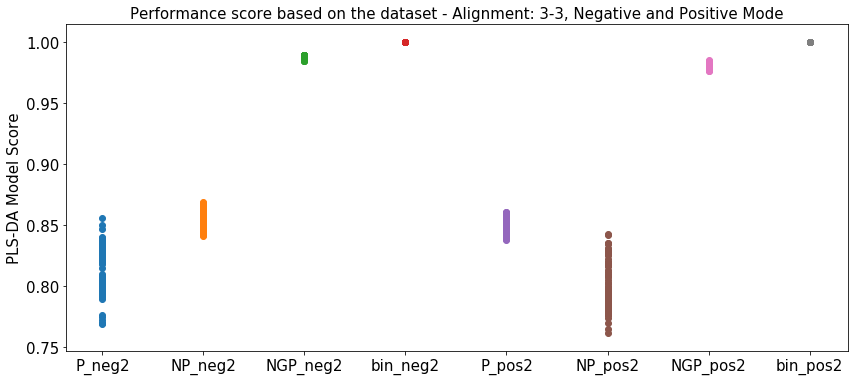

In [138]:
f, ax = plt.subplots(figsize=(14,6))
for name, data in PLS_score.items():
    if name.endswith('2'):
        plt.scatter([name]*len(data), data)
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Performance score based on the dataset - Alignment: 3-3, Negative and Positive Mode', fontsize = 15)
plt.show()

### Accuracies and Scores Summary - With Medians but also still with standard deviations

In [139]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.median(PLS_accu[name])
    Score[name] = np.median(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

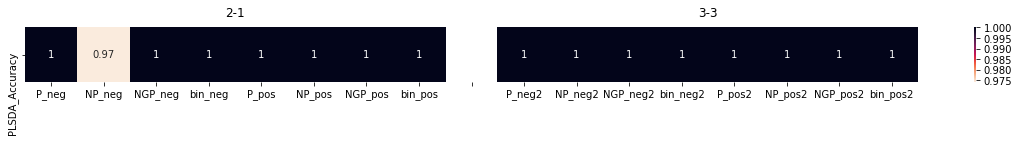

In [140]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Accuracy_H = pd.concat([Accuracy_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Accuracy_H.iloc[:,8:]], axis = 1)

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

plt.text(4,-0.2,'2-1', fontsize  = 12, horizontalalignment='center')
plt.text(13,-0.2,'3-3', fontsize  = 12, horizontalalignment='center')
plt.show()

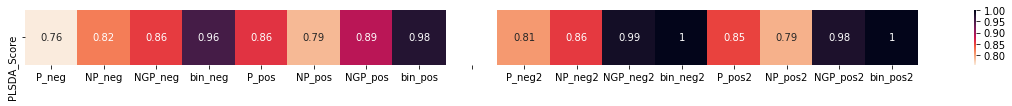

In [141]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Score_H = pd.concat([Score_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Score_H.iloc[:,8:]], axis = 1)

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [142]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).iloc[:8].T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())[:8]
Accuracy_H.T

Accuracy        SD
P_neg    1.000000  0.000000
NP_neg   0.974359  0.010059
NGP_neg  1.000000  0.010256
bin_neg  1.000000  0.000000
P_pos    1.000000  0.000000
NP_pos   1.000000  0.000000
NGP_pos  1.000000  0.000000
bin_pos  1.000000  0.000000

In [143]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).iloc[:8].T
Score_H.loc['SD'] = list(Score_std.values())[:8]
Score_H.T

Score        SD
P_neg    0.756100  0.019016
NP_neg   0.822010  0.007057
NGP_neg  0.855756  0.011773
bin_neg  0.955915  0.000493
P_pos    0.860460  0.006741
NP_pos   0.787543  0.006061
NGP_pos  0.887930  0.002585
bin_pos  0.976531  0.000299

### Similarity in Feature Selection between the different methods

Objective: See the similarity in features chosen with the different methods employed in model_PLSDA by seeing the percentage of features shared between each pair of the methods in 2% most important features chosen in each case.

In [144]:
def Feat_Selection_sim(VIP_s, Weight_s, RegCoef_s, percent = 0.02):
    """See the similarity of features chosen (% of intersection between them) with different methods."""
    number = round(percent*len(VIP_s))
    VIP = []
    Weights = []
    RegCoef = []
    for i in range(number):
        VIP.append(VIP_s[:number][i][0])
        Weights.append(Weight_s[:number][i][0])
        RegCoef.append(RegCoef_s[:number][i][0])
    Features = (VIP, Weights, RegCoef)
    Table = pd.DataFrame(np.empty((3,3)), columns = ['VIP', 'Weights', 'RegCoef'], index = ['VIP', 'Weights', 'RegCoef'])
    for i in range(len(Features)):
        for j in range(len(Features)):
            #list comprehension other way
            Table.iloc[i,j] = len(set(Features[i]).intersection(Features[j]))/number
    return Table

In [145]:
for i in PLS_weights:
    if not i.endswith('2'):
        print(i)
        print(Feat_Selection_sim(PLS_VIP[i], PLS_weights[i], PLS_RegCoef[i], percent = 0.02))
        print('\n')

P_neg
              VIP   Weights   RegCoef
VIP      1.000000  0.363636  0.833333
Weights  0.363636  1.000000  0.469697
RegCoef  0.833333  0.469697  1.000000


NP_neg
              VIP   Weights   RegCoef
VIP      1.000000  0.606061  0.727273
Weights  0.606061  1.000000  0.681818
RegCoef  0.727273  0.681818  1.000000


NGP_neg
              VIP   Weights   RegCoef
VIP      1.000000  0.666667  0.484848
Weights  0.666667  1.000000  0.363636
RegCoef  0.484848  0.363636  1.000000


bin_neg
              VIP   Weights   RegCoef
VIP      1.000000  0.348485  0.787879
Weights  0.348485  1.000000  0.393939
RegCoef  0.787879  0.393939  1.000000


P_pos
              VIP   Weights   RegCoef
VIP      1.000000  0.621359  0.864078
Weights  0.621359  1.000000  0.601942
RegCoef  0.864078  0.601942  1.000000


NP_pos
              VIP   Weights   RegCoef
VIP      1.000000  0.563107  0.582524
Weights  0.563107  1.000000  0.669903
RegCoef  0.582524  0.669903  1.000000


NGP_pos
              VIP   Weight

There is significant overlap between the variables chosen between the 3 different methods, so to be more computationally efficient we will use the mroe simpler methods of X_weigths and Regression Coefficients since the function to calculate VIP is considerably slower which in turn also helps in case the calculate vips function has some mistake in its construction.

Therefore from now on, we will use the model_PLSDA function wihtout the VIP calculating section present in the module multianalysis.py, which will lead to much faster iterations of PLS-DA.

### Characteristics of the most important features - still mean (not median)

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [146]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
PLS_feat = (PLS_weights, PLS_RegCoef, PLS_VIP)
ev = []
magni = []
index = []
for m in PLS_feat:
    for name in m:
        if name.endswith('neg'):
            Spectra = aligned_all_neg
        elif name.endswith('pos'):
            Spectra = aligned_all_pos
        elif name.endswith('neg2'):
            Spectra = aligned_all_neg2
        elif name.endswith('pos2'):
            Spectra = aligned_all_pos2

        imp_features = m[name]

        index.append(name)
        ratio = []
        nsamples = []
        n_groups = []

        #Top 2%
        number = round(0.02*len(Spectra))
        total_m = 0

        for i in range(len(imp_features)):
            total_m = total_m + imp_features[i][1]
        magni.append(imp_features[0][1]/(total_m/len(Spectra)))
        for i in range(number): 
            ngroups = {}
            line = Spectra.loc[imp_features[i][2],:].notnull()
            nsamples.append(line.sum())
            for n in range(len(line)):
                if line[n] == True:
                    ngroups[Spectra.cdl.labels[n]] = 1
            n_groups.append(sum(list((ngroups.values()))))
            ratio.append(nsamples[-1]/n_groups[-1])
        df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
        df['nsamples'] = nsamples
        df['n_groups'] = n_groups
        df['ratio']  = ratio
        ev.append(df)

In [147]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df_W = pd.concat([df.iloc[:4], line, df.iloc[4:8], line, df.iloc[8:12], line, df.iloc[12:16]])
df_RC = pd.concat([df.iloc[16:20], line, df.iloc[20:24], line, df.iloc[24:28], line, df.iloc[28:32]])
df_VIP = pd.concat([df.iloc[32:36], line, df.iloc[36:40], line, df.iloc[40:44], line, df.iloc[44:]])

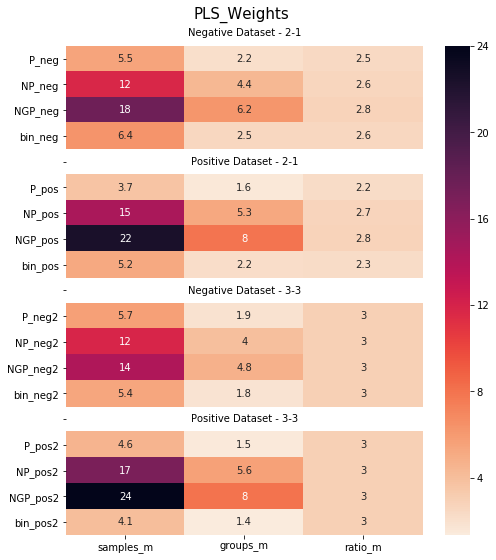

In [148]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df_W, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS_Weights', fontsize = 15, x = 0.43, y = 0.94)
plt.text(1.5,-0.5,'Negative Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,9.5,'Negative Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,14.5,'Positive Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.show()

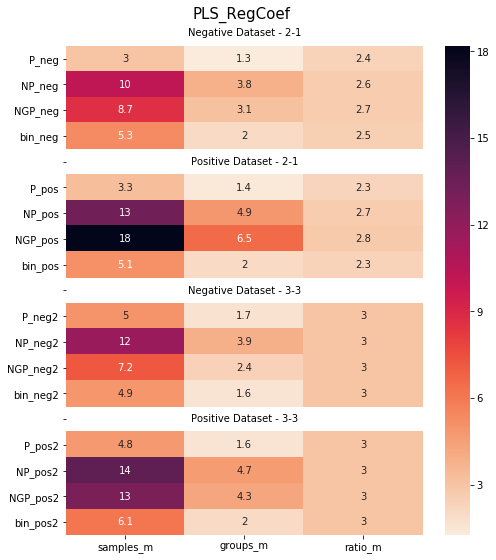

In [149]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df_RC, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS_RegCoef', fontsize = 15, x = 0.43, y = 0.94)
plt.text(1.5,-0.5,'Negative Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,9.5,'Negative Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,14.5,'Positive Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.show()

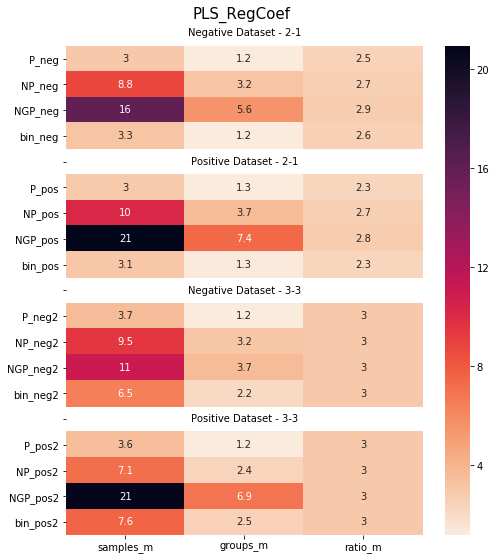

In [150]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df_VIP, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS_RegCoef', fontsize = 15, x = 0.43, y = 0.94)
plt.text(1.5,-0.5,'Negative Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset - 2-1',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,9.5,'Negative Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,14.5,'Positive Dataset - 3-3',horizontalalignment='center', verticalalignment='center')
plt.show()

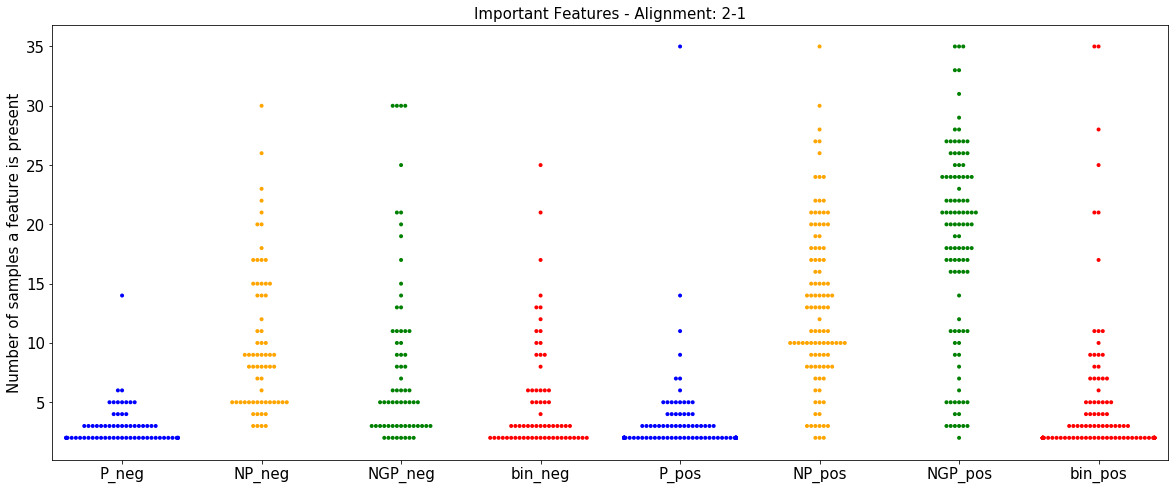

In [151]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#sns.violinplot(data=data)
sns.swarmplot(data=data[16:24], size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_RegCoef.keys())[i] for i in range(len(PLS_RegCoef.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.title('Important Features - Alignment: 2-1', fontsize = 15)
plt.show()

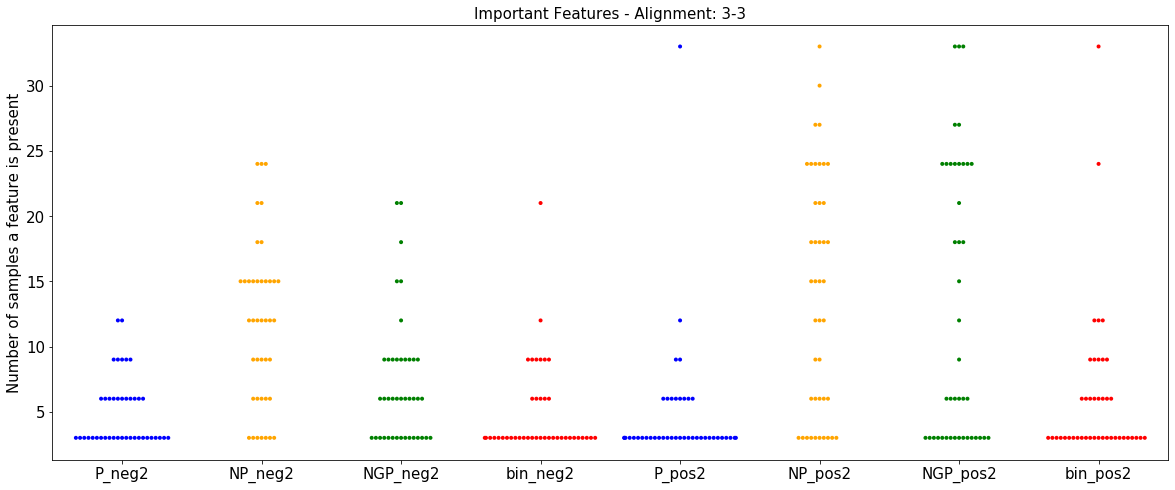

In [152]:
f, ax = plt.subplots(figsize=(20,8))
#sns.violinplot(data=data)
sns.swarmplot(data=data[24:32], size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_RegCoef.keys())[i] for i in range(8,len(PLS_RegCoef.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.title('Important Features - Alignment: 3-3', fontsize = 15)
plt.show()

In [153]:
print('Magnitude of most important features for each case:')
for i in range(16):
    print(list(PLS_RegCoef.keys())[i], '     \t', magni[16+i])

Magnitude of most important features for each case:
P_neg      	 5.004668956221468
NP_neg      	 10.075561967465308
NGP_neg      	 6.811698909047283
bin_neg      	 3.876360116811705
P_pos      	 6.6018672040602615
NP_pos      	 5.629089736877539
NGP_pos      	 9.532262655402851
bin_pos      	 4.654006116522106
P_neg2      	 7.706045060823874
NP_neg2      	 14.042575003381375
NGP_neg2      	 7.62504082590228
bin_neg2      	 5.063761317397042
P_pos2      	 11.478943883857847
NP_pos2      	 4.469302798842605
NGP_pos2      	 7.571538586780931
bin_pos2      	 5.29455038594802


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

#### NGP data treatment for the Negative Mode - Alignment: 2-1

In [154]:
from sklearn.cross_decomposition import PLSRegression

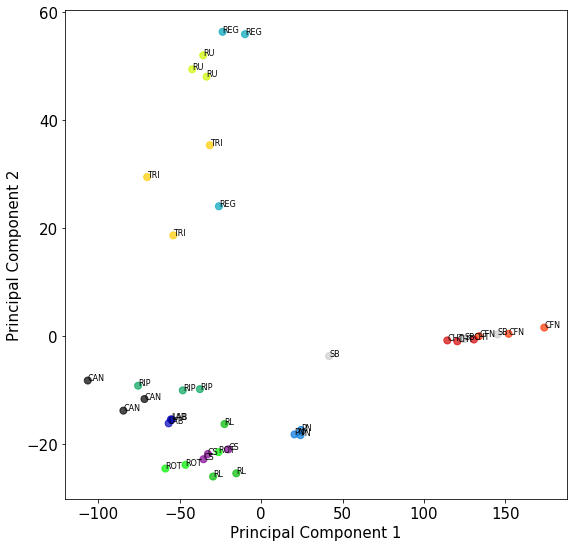

In [155]:
plsda = PLSRegression(n_components = 15, scale = False)
#Fitting the model and getting the X_scores
plsda.fit(X=NGP_neg.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 13)
col_lbl = colours(range(13))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = NGP_neg.cdl.unique_labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

#### Binary processed data for the negative mode - Alignment: 2-1

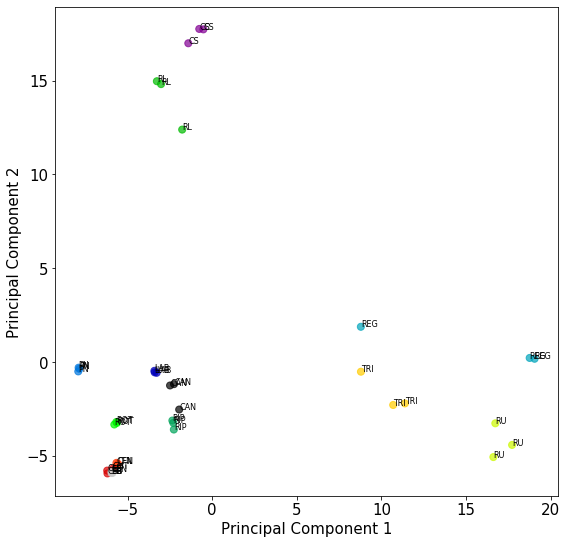

In [156]:
plsda = PLSRegression(n_components = 15, scale = False)
#Fitting the model and getting the X_scores
plsda.fit(X=aligned_neg.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 13)
col_lbl = colours(range(13))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

#Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = aligned_neg.cdl.unique_labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

#### NGP data treatment for the Negative Mode - Alignment: 3-3

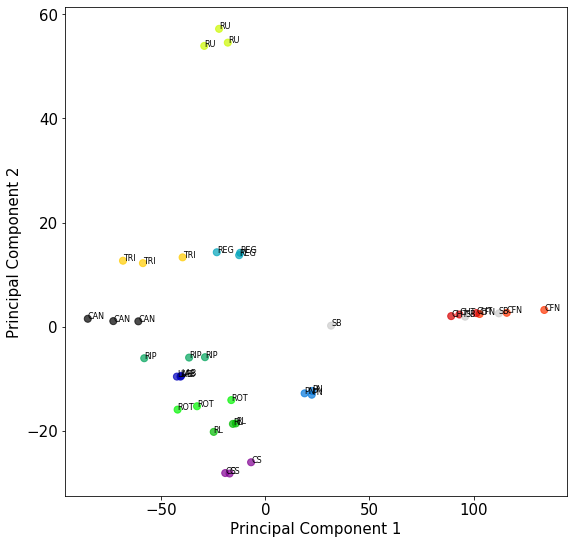

In [157]:
plsda = PLSRegression(n_components = 15, scale = False)
#Fitting the model and getting the X_scores
plsda.fit(X=NGP_neg2.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 13)
col_lbl = colours(range(13))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.cdl.unique_labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

#### Binary processed data for the negative mode - Alignment: 3-3

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:292: UserWarning: Y residual constant at iteration 12
  warnings.warn('Y residual constant at iteration %s' % k)


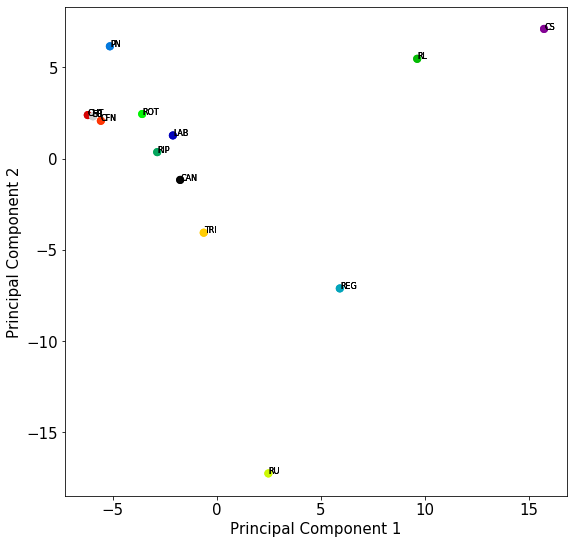

In [158]:
plsda = PLSRegression(n_components = 15, scale = False)
#Fitting the model and getting the X_scores
plsda.fit(X=aligned_neg2.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 13)
col_lbl = colours(range(13))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

#Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.cdl.unique_labels[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Use of function `permutation_RF` in multianalysis.py

In [159]:
CV = {}
PMs = {}
pvalue = {}

In [160]:
all_data = (P_neg, NP_neg, NGP_neg, aligned_neg, P_pos, NP_pos, NGP_pos, aligned_pos,
           P_neg2, NP_neg2, NGP_neg2, aligned_neg2, P_pos2, NP_pos2, NGP_pos2, aligned_pos2)
names = ('P_neg', 'NP_neg', 'NGP_neg', 'bin_neg', 'P_pos', 'NP_pos', 'NGP_pos', 'bin_pos',
        'P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for P_neg ...
Done!
Permutation test (Random Forest) for NP_neg ...
Done!
Permutation test (Random Forest) for NGP_neg ...
Done!
Permutation test (Random Forest) for bin_neg ...
Done!
Permutation test (Random Forest) for P_pos ...
Done!
Permutation test (Random Forest) for NP_pos ...
Done!
Permutation test (Random Forest) for NGP_pos ...
Done!
Permutation test (Random Forest) for bin_pos ...
Done!
Permutation test (Random Forest) for P_neg2 ...
Done!
Permutation test (Random Forest) for NP_neg2 ...
Done!
Permutation test (Random Forest) for NGP_neg2 ...
Done!
Permutation test (Random Forest) for bin_neg2 ...
Done!
Permutation test (Random Forest) for P_pos2 ...
Done!
Permutation test (Random Forest) for NP_pos2 ...
Done!
Permutation test (Random Forest) for NGP_pos2 ...
Done!
Permutation test (Random Forest) for bin_pos2 ...
Done!


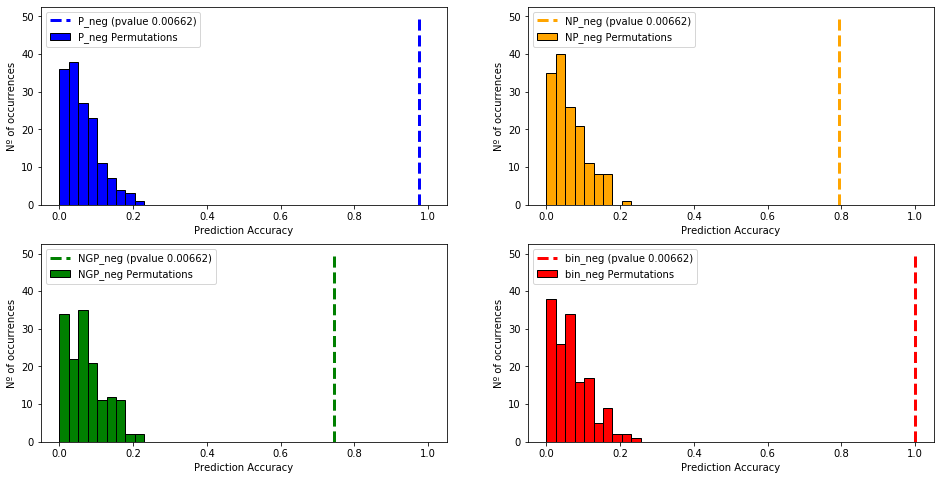

In [161]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'bin_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

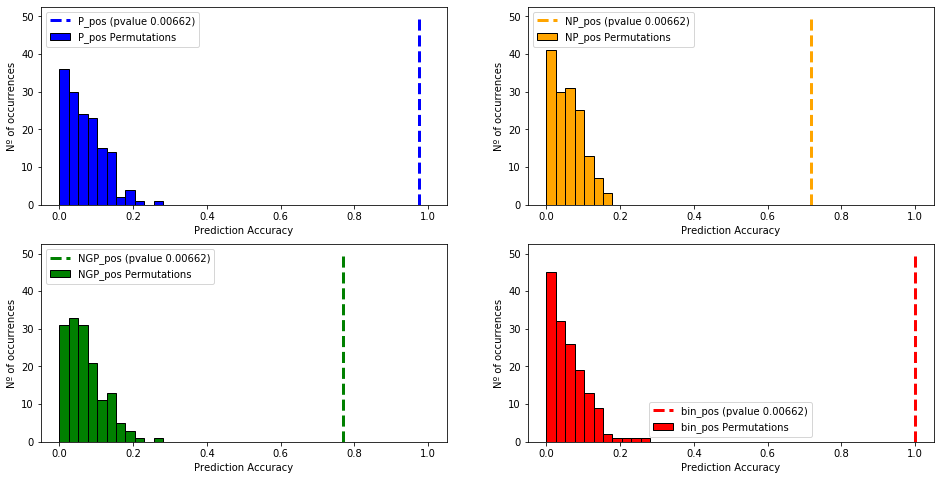

In [162]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'bin_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

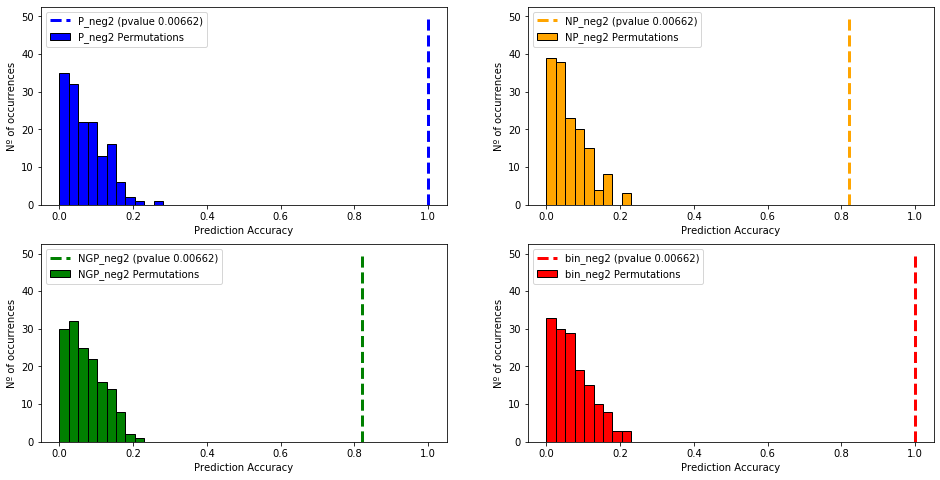

In [163]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

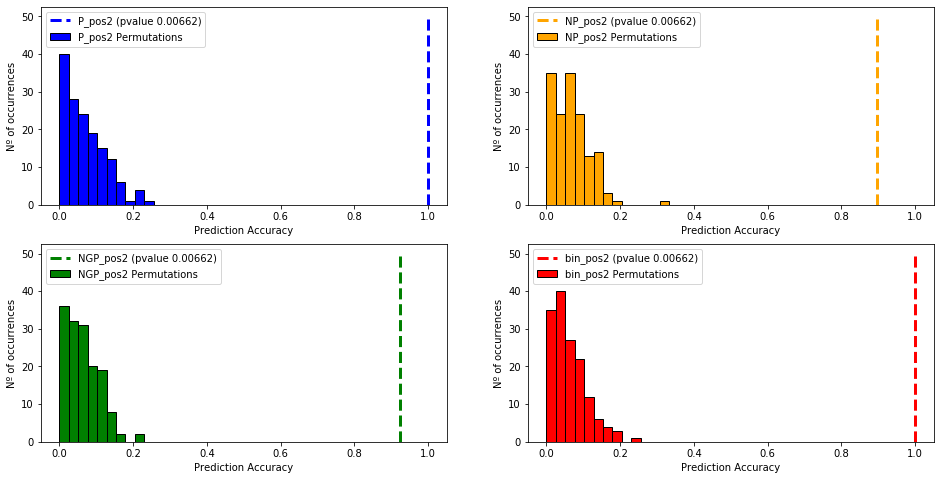

In [164]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [165]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [166]:
all_data = (P_neg, NP_neg, NGP_neg, aligned_neg, P_pos, NP_pos, NGP_pos, aligned_pos,
           P_neg2, NP_neg2, NGP_neg2, aligned_neg2, P_pos2, NP_pos2, NGP_pos2, aligned_pos2)
names = ('P_neg', 'NP_neg', 'NGP_neg', 'bin_neg', 'P_pos', 'NP_pos', 'NGP_pos', 'bin_pos',
        'P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2')

for name, data in zip(names, all_data):
    if name == 'bin_neg2':
        print(f'permutation test (PLS-DA) for {name} ...')
        permuta = ma.permutation_PLSDA(data, n_comp=10, iter_num=150)
        CV_PLS[name] = permuta[0]
        PMs_PLS[name] = permuta[1]
        pvalue_PLS[name] = permuta[2]
        print('Done!')
    elif name == 'bin_pos2':
        print(f'permutation test (PLS-DA) for {name} ...')
        permuta = ma.permutation_PLSDA(data, n_comp=10, iter_num=150)
        CV_PLS[name] = permuta[0]
        PMs_PLS[name] = permuta[1]
        pvalue_PLS[name] = permuta[2]
        print('Done!')
    else:
        print(f'permutation test (PLS-DA) for {name} ...')
        permuta = ma.permutation_PLSDA(data, n_comp=15, iter_num=150)
        CV_PLS[name] = permuta[0]
        PMs_PLS[name] = permuta[1]
        pvalue_PLS[name] = permuta[2]
        print('Done!')

permutation test (PLS-DA) for P_neg ...
Done!
permutation test (PLS-DA) for NP_neg ...
Done!
permutation test (PLS-DA) for NGP_neg ...
Done!
permutation test (PLS-DA) for bin_neg ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for P_pos ...
Done!
permutation test (PLS-DA) for NP_pos ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NGP_pos ...
Done!
permutation test (PLS-DA) for bin_pos ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for P_neg2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NP_neg2 ...
Done!
permutation test (PLS-DA) for NGP_neg2 ...
Done!
permutation test (PLS-DA) for bin_neg2 ...
Done!
permutation test (PLS-DA) for P_pos2 ...
Done!
permutation test (PLS-DA) for NP_pos2 ...
Done!
permutation test (PLS-DA) for NGP_pos2 ...
Done!
permutation test (PLS-DA) for bin_pos2 ...


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:322: UserWarning: X scores are null at iteration 9
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:322: UserWarning: X scores are null at iteration 9
  warnings.warn('X scores are null at iteration %s' % k)


Done!


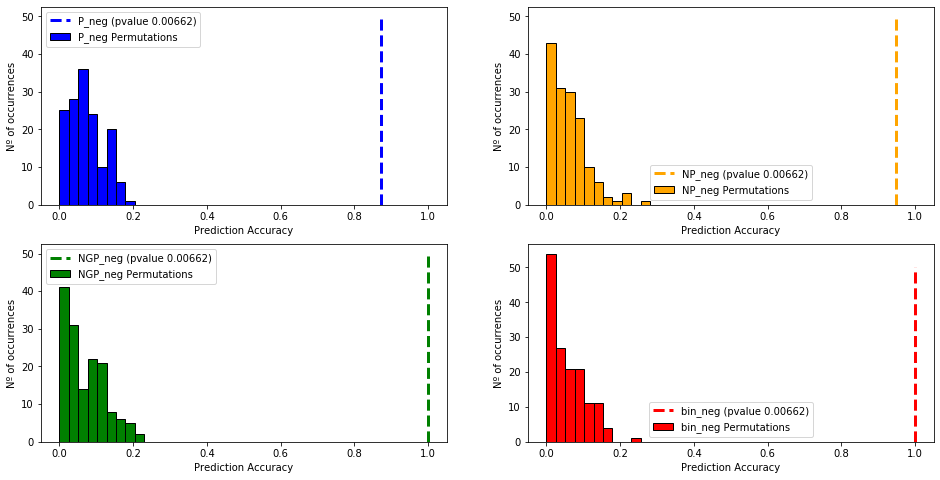

In [167]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'bin_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

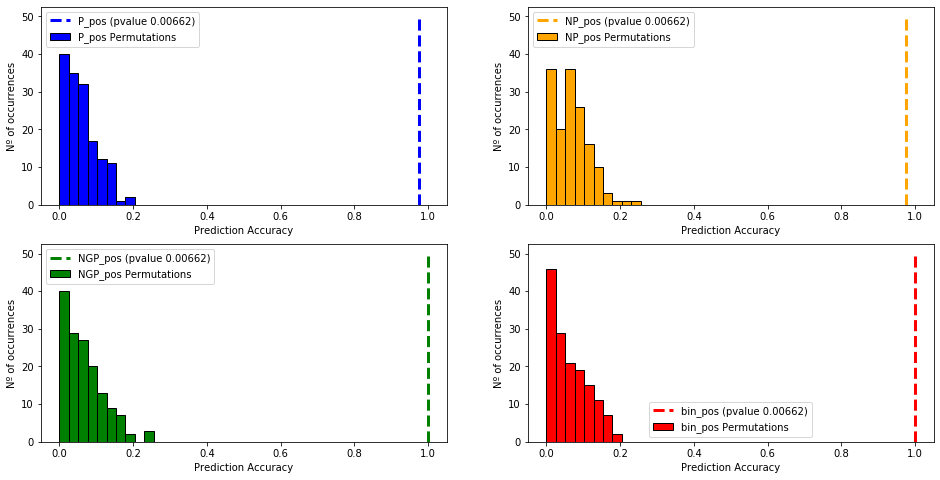

In [168]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'bin_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

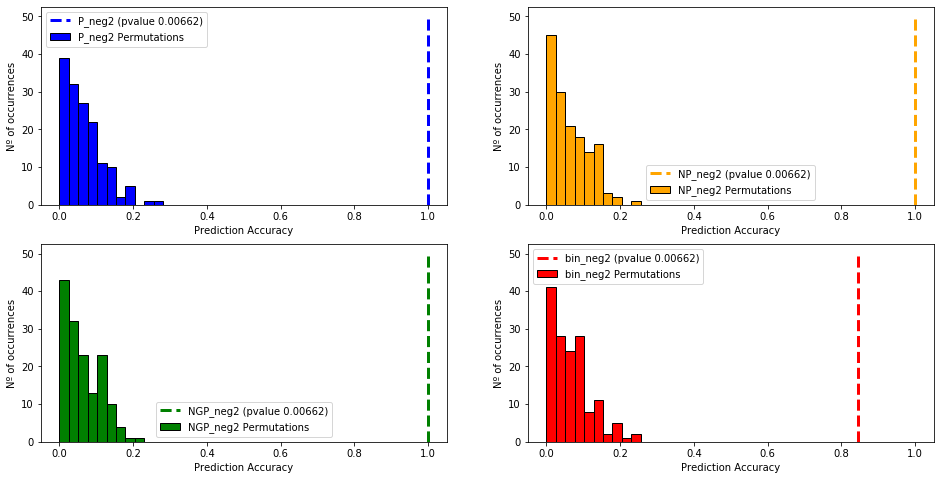

In [169]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'bin_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

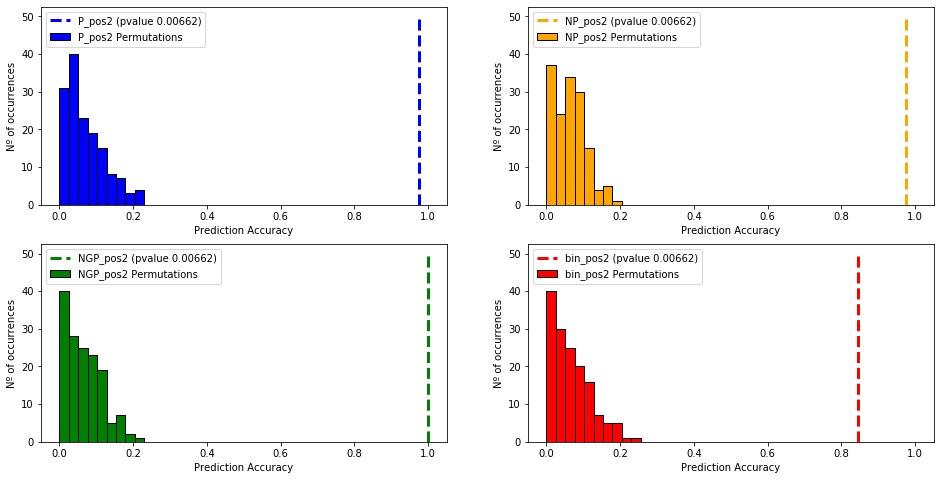

In [170]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'bin_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

## Discussion of day 6/11/2019 and forward not present here - Incomplete

### Results summary of dendrograms made with the heatmaps

- Results similar for all 3 methods of calculating the correlation between different hierarchical clusterings.
- 2 big clusters formed based on the similarity of the correlations between different hierarchical clusterings (made with different distance metrics.
- One cluster with the binary measures: hamming, sokalmichener and rogerstanimoto; the other with: dice, jaccard, sokalsneath, yule, russellrao, kulsinski (this last two seem farther away than the rest).
- There is some difference between negative and positive datasets, however this difference isn't too big.
- Note that almost all of the correlation coefficients between groups are positive so most of them tend to show the same "major" trends in the data. However, after Pareto Scaling correction, the correlation values seem lower and there is a greater number of negative correlations (even if really small).

##### Comparison with Euclidean Distances
- Pareto Scaled data makes sample proximity based on euclidean distances closer to hamming, sokalmichener and rogerstanimoto binary distances.
- Normalized by reference features before Pareto Scaling data makes sample proximity based on euclidean distances be closer to all other binary measures: dice, jaccard, sokalsneath, yule, (russellrao, kulsinski). The positive dataset is still considerably separated even from its closest binary measures. Normalization also seems to prevent early separation of varieties with low number of peaks (samples CHT, SB and CFN). 
- glog transformation (currently only log transformation*2 - lacks glog optimization algorithm - to do (adding)) after normalization (and before Pareto Scaling) on the data seems becomes closer to the original Pareto Scaled data in the dendrograms for the positive dataset while it stays in the same cluster (as the normalized negative dataset) for the negative dataset. Also lambda seems to have a very small effect on the results (see MetAnalyst_Example.ipynb as an example).
- glog transformation without normalization data's results are very close to the glog transformation after normalization that were mentioned before and, as such, they aren't shown in the dendrogram to facilitate analysis.
- (One difference that can be one of the major reasons behind this 2 cluster groups and euclidean metrics shifting based on the data procesing may be the following: if the first "cluster separation" in each dendrogram starts with separating the varieties CHT, SB and CFN or not (and normally separating TRI, REG, RU) from the rest of the group.)
- Overall, the results seem difficult to interpret about which binary measure is closer to the results given using the conventional Euclidean Distances since the latter's result depend on the data processing that is made.
- Euclidean distances also don't allow to separate the different varieties individually very effectively and only separate them in "cluster of varieties" that are closer to eachother.

##### Comparison between the different peak alignments made and analysed with Euclidean Distances
- The two peak alignments seem to produce very similar results.
- The groups of the two peak alignments that suffer the same kind of data processing often "cluster" with each other (are closer to each other) than any other group in all 3 correlation metrics.
- Other peak alignments may change the previous results slightly but never too much (to alter the conclusions had). Example: requiring features to appear in 1/3 (13) of the samples: negative dataset without transformation is distant (close to euc_NP_pos as seen above) but the rest of results have the same conclusions - the positive dataset with this peak alignment is really close to the first positive dataset used here. 

##### Checking if the data processing gives similar results to the one made in MetaboAnalyst
- Check Jupyter Notebook MetAnalyst_Example.ipynb.

##### Checking if the data processing gives similar results without CHT, SB and CFN varieties
- Correlation values in general higher without those varieties.
- Dendrogram of individual distance metrics seem to be able to separate varieties better (not in all cases though).
- Hierarchical clustering of the correlation coeficients of dendrograms need more analysis however it seems like euclidean distances seem to be in general closer to hamming, sokalmichener, rogerstanimoto and yule binary measures than others (specially in the cophenetic correlation coefficients). The normalized positive dataset is really distant from other euclidean distances and most binary distances apart from kulsinki and russellrao that tend to have slightly negative correlations with other distances.



log menos erros, falar do problema do especial do 2-1.

#### Some functions that might be useful in the future

In [171]:
def reord_samples(DisorderedSpectra, OrderedSpectra):
    """Make a spectra have the same sample order than another.
    
       DisorderedSpectra, OrderedSpectra: AlignedSpectra objects (from metabolinks).
       
       Returns: AlignedSpectra object (from metabolinks); DisorderedSpectra ordered by the samples of Ordered Spectra.
       """
    ordered = DisorderedSpectra.data[OrderedSpectra.sample_names] 
    Reordered = AlignedSpectra(ordered, sample_names=OrderedSpectra.sample_names, labels=OrderedSpectra.sample_names.labels)
    return Reordered

In [172]:
#Needs - scipy.cluster.hierarchy as hier 
def Coph_Trans(Z, zdist):
    """Transforms the cophenet distances given by the function scypy.hierarchy.cophenet into a triangular matrix.
    
       Z: 2-D array; the return of the linkage function in scypy.stats.hierarchy.
       zdist: ndarray; the return of the distance function in scypy.spatial.distance.
       
       Returns: cophenetic correlation distance and a cophenetic distance matrix.
    """
    
    #Z2 = scipy.cluster.hierarchy.cophenet(Z, zdist)
    Z2 = hier.cophenet(Z, zdist)
    CCM = np.zeros((len(Z)+1, len(Z)+1))
    n = 0
    for i in range(0,len(Z)):
        j = i + 1
        while j < len(Z)+1:
            CCM[j,i] = Z2[1][n]
            j = j + 1
            n = n + 1
    return Z2[0], CCM

In [173]:
def Dendrogram_prep(Spectra, minsample = 0, metric = 'euclidean', method = 'average'):
    """Hierarchical clustering of a spectra (feature removal, missing value imputation, Pareto scaling and linkage algorithm).
    
       Spectra: AlignedSpectra object (from metabolinks).
       minsample: scalar, optional; number between 0 and 1, minsample*100 is the minimum % of samples where the feature must
    be present in order to not be removed.
       metric: string, optional; type of distance metrics to use (distances betweens samples). Distance metrics: {'euclidean', 
    'dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao'}.
       method: string, optional; type of linkage algorithm to use. Types of methods: {'ward', 'average', 'centroid', 'single',
    'complete', 'weighted', 'median'}.
       
       Returns: (ndarray, ndarray); hierarchical clustering encoded as a linkage matrix, respective condensed distance matrix.
    """
    
    binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
    if metric in binary:
        Bool = df_to_bool(Spectra.data)
        Dist = dist.pdist(Bool.T, metric = metric)
    else:
        Imputated = sca.NaN_Imputation(Spectra, minsample)
        Scaled = sca.ParetoScal(Imputated)
        Dist = dist.pdist(Scaled.data.T, metric = metric)
    
    Z = hier.linkage(Dist, method = method)
    Data = (Z, Dist)
    return Data